# In this Notebook we show the result of NetMHCIIpan 4.1 analysis
## Importing data from NetMHCIIpan output

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import plotly.express as px
from statannotations.Annotator import Annotator  # Use statannotations
from itertools import combinations
import csv
import re
import numpy as np

/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_51842/2733291251.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [126]:
# output_netmhciipan = '/Users/gabrielinnocenti/Desktop/phd_tmp/Projects/HLA_project_2024/HLA-II_AntibodySpecificityAssociations/NetMHCII-predictions/final_output_only_peptides.txt'
output_netmhciipan = '/Users/gabrielinnocenti/Desktop/phd_tmp/Projects/HLA_project_2024/HLA-II_AntibodySpecificityAssociations/NetMHCII-predictions/final_output_proteins_agilent.txt'
df_agilent = pkl.load(open('/Users/gabrielinnocenti/Desktop/phd_tmp/Sequencing_runs/Sequencing_19_02_24/libraries_metadata/df_info_agilent_final_complete.pkl', 'rb')).reset_index()
annotations = pd.read_csv('Merged_HLA_imputations_Peptides_annotations.tsv', sep='\t')
output_netmhciipan_GWAS_tested = '/Users/gabrielinnocenti/Desktop/phd_tmp/Projects/HLA_project_2024/HLA-II_AntibodySpecificityAssociations/NetMHCII-predictions/final_output_non_associated_peptides.txt'
summary_non_associated_binders_all_combinations = '/Users/gabrielinnocenti/Desktop/phd_tmp/Projects/HLA_project_2024/HLA-II_AntibodySpecificityAssociations/data/to_analyze/formatted_results_combinatorial_analysis_not_associated_proteins.txt'
df_associations = pd.read_excel('/Users/gabrielinnocenti/Desktop/phd_tmp/Projects/HLA_project_2024/HLA-II_AntibodySpecificityAssociations/data/mmc3.xlsx', sheet_name='SupTable2.2')


In [297]:
# Import the output of netMHC_out_to_df
def netMHC_out_to_df(output_netmhciipan, method=1):
    data = []
    if method == 1:
        with open(output_netmhciipan) as netMHCII:
            for line in netMHCII:
                if 'prot' in line:
                    line = line.strip()
                    line = re.sub(r"\s+", "\t", line)  # Convert spaces to tabs
                    data.append(line)
        
        # Use csv.reader to handle inconsistent spacing properly
        from io import StringIO
        data_io = StringIO("\n".join(data))
        reader = csv.reader(data_io, delimiter="\t")
        
        df = pd.DataFrame(reader)

        # Adjust column names based on observed structure
        df.columns = [
            'Pos', 'MHC', 'Peptide', 'Of', 'Core', 'Core_Rel', 'Inverted', 
            'peptide_name', 'Score_EL', '%Rank_EL', 'Exp_Bind', 'BindLevel'
        ][:df.shape[1]]  # Trim if extra columns exist
        # Convert list of tab-separated lines into a DataFrame
        df = pd.DataFrame([line.strip().split("\t") for line in data])
        df.columns = ['Pos', 'MHC', 'Peptide','Of', 'Core', 'Core_Rel', 'Inverted', 'peptide_name', 'Score_EL', '%Rank_EL', 'Exp_Bind', 'BindLevel']

    elif method == 2:
        with open(output_netmhciipan) as netMHCII:
            for line in netMHCII:
                if 'prot' in line:
                    line = line.strip()
                    line = re.sub(r"\s+", "\t", line)
                    data.append(line)


        # Convert list of tab-separated lines into a DataFrame
        df = pd.DataFrame([line.strip().split("\t") for line in data])
        df.columns = ['Pos', 'MHC', 'Peptide','Of', 'Core', 'Core_Rel', 'peptide_name', 'Score_EL', '%Rank_EL', 'Exp_Bind', 'BindLevel']

    return df

# Create a summary boxplots in which is possible to see difference between different Classes in the input Df, tested using Mann whitney or t-test
def create_boxplot_summary(df, ax=None, x='MHC', on_group='Class', test='MW'):
    # Define all possible pairs within each MHC group
    pairs = []
    if len(df[x].unique()) > 2:
        for mhc_group in df[x].unique():
            class_combinations = list(combinations(df[df[x] == mhc_group][on_group].unique(), 2))
            for comb in class_combinations:
                pairs.append(((mhc_group, comb[0]), (mhc_group, comb[1])))
                

            # Create annotator object and apply statistical tests
            annotator = Annotator(ax, pairs, data=df, x=x, hue=on_group, y='Pos')
        if test=='ttest':
            annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
        elif test=='MW':
            annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')

        annotator.apply_and_annotate()
    else:
        # Get unique class names
        classes = df[x].unique()
        pair = [(classes[0], classes[1])]

        # Run the t-test
        data1 = df[df['Class'] == classes[0]]['Percentage']
        data2 = df[df['Class'] == classes[1]]['Percentage']
        # stat, pval = ttest_ind(data1, data2, equal_var=False)

        # Add significance annotation
        annotator = Annotator(ax, pair, data=df, x='Class', y='Percentage')
        annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=0)
        annotator.apply_and_annotate()
        mean_x1 = np.mean(df[df['Class'] == 'Associated']['Pos']) 
        mean_x2 = np.mean(df[df['Class'] == 'Not associated']['Pos'])
        numerator = mean_x1 - mean_x2
        denominator = np.sqrt(np.var(df[df['Class'] == 'Associated']['Pos']) +\
                np.var(df[df['Class'] == 'Not associated']['Pos'])/2)
        smd = numerator / denominator
        print(f'Standardized Mean: {smd}')
        # if correction:
        #     # Run statistical tests manually to get p-values
        #     raw_pvals = []
        #     for (group1, group2) in pairs:
        #         df_group1 = df[(df['MHC'] == group1[0]) & (df['Class'] == group1[1])]['Pos']
        #         df_group2 = df[(df['MHC'] == group2[0]) & (df['Class'] == group2[1])]['Pos']
                
        #         stat, p = ttest_ind(df_group1, df_group2, equal_var=False)  # or Mann-Whitney
        #         raw_pvals.append(p)

        #     # Apply Benjamini-Hochberg correction
        #     reject, corrected_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')

        #     # Create a list of manually corrected results
        #     stat_results = [(p, "p = {:.3f}".format(p)) for p in corrected_pvals]

        #     # Apply corrected p-values to Annotator
        #     annotator.set_pvalues_and_annotate(stat_results)
        # else:

    

    plt.legend(loc='upper right')
    plt.title("Distribution Comparison with Statistical Significance")
    plt.ylabel('Binders Percentage (%)')
    plt.show()




def create_summarized_groups(df, group_on=None):
    df_grouped_by_binding = df.groupby(group_on).count().reset_index()

    df.sort_values(by=['peptide_name', '%Rank_EL'], ascending=[False, True])[['peptide_name', 'Peptide', 'Core', 'MHC', '%Rank_EL', 'Score_EL', 'BindLevel']]

    df_grouped_slid_wind =df.groupby(group_on).count()

    tot_vals = []
    for pept, mhc in df_grouped_slid_wind.reset_index()[['peptide_name', 'MHC']].values:
        total_values = len(df[(df['peptide_name'] == pept) & (df['MHC'] == mhc)])
        tot_vals.append(total_values)

    df_grouped_slid_wind['Size'] = tot_vals
    df_grouped_slid_wind['Percentage'] = round(df_grouped_slid_wind['Pos'] / df_grouped_slid_wind['Size'] * 100, 3)
    return df_grouped_slid_wind.reset_index()




In [37]:

# df_grouped.to_excel('Test_alleles_binding.xlsx')

## Internal control: perform comparison between HLA-II binders in proteins associated vs. the alleles they are associated and proteins associated vs. alleles which they are not associated to

In [298]:
def internal_samples_analysis(df1, df2, df_annotations_and_mapping_imputations):
    # df_grouped_slid_wind_reidx = df1.reset_index()
    list_HLA = []
    list_associations = []
    for prot,allele in df1[['peptide_name', 'MHC']].values:
        if 'DRB' not in allele:
            allele_A = allele.split('-')[1]
            allele_B = allele.split('-')[2]
            allele_HLA_A = f'HLA_{allele_A[:4]}_{allele_A[4:]}'
            allele_HLA_B = f'HLA_{allele_B[:4]}_{allele_B[4:]}'
            # print(allele_HLA_A)
            len_df_both_alleles = len(df_annotations_and_mapping_imputations[(df_annotations_and_mapping_imputations['prot_num'] == prot) & \
                                                            (df_annotations_and_mapping_imputations['Variant'] == allele_HLA_A)]) + \
                                                            len(df_annotations_and_mapping_imputations[(df_annotations_and_mapping_imputations['prot_num'] == prot) & \
                                                            (df_annotations_and_mapping_imputations['Variant'] == allele_HLA_B)])
            # print(f'Found matches to {allele}: {len_df_both_alleles}')
            if len_df_both_alleles != 0:
                list_HLA.append((prot,[allele_HLA_A, allele_HLA_B]))
                list_associations.append('Associated')
            else:
                list_associations.append('Not associated')
        else:
            allele_HLA = f'HLA_{allele}'
            len_df_allele_DRB = len(df_annotations_and_mapping_imputations[(df_annotations_and_mapping_imputations['prot_num'] == prot) & \
                                                            (df_annotations_and_mapping_imputations['Variant'] == allele_HLA)])
            # print(f'Found matches to {allele}: {len_df_allele_DRB}')
            if len_df_allele_DRB != 0:
                list_HLA.append((prot,[allele]))
                list_associations.append('Associated')
            else:
                list_associations.append('Not associated')


    df1['Class'] = list_associations


    list_HLA = []
    list_associations = []
    for prot,allele in df2[['peptide_name', 'MHC']].values:
        if 'DRB' not in allele:
            allele_A = allele.split('-')[1]
            allele_B = allele.split('-')[2]
            allele_HLA_A = f'HLA_{allele_A[:4]}_{allele_A[4:]}'
            allele_HLA_B = f'HLA_{allele_B[:4]}_{allele_B[4:]}'
            # print(allele_HLA_A)
            len_df_both_alleles = len(df_annotations_and_mapping_imputations[(df_annotations_and_mapping_imputations['prot_num'] == prot) & \
                                                            (df_annotations_and_mapping_imputations['Variant'] == allele_HLA_A)]) + \
                                                            len(df_annotations_and_mapping_imputations[(df_annotations_and_mapping_imputations['prot_num'] == prot) & \
                                                            (df_annotations_and_mapping_imputations['Variant'] == allele_HLA_B)])
            # print(f'Found matches to {allele}: {len_df_both_alleles}')
            if len_df_both_alleles != 0:
                list_HLA.append((prot,[allele_HLA_A, allele_HLA_B]))
                list_associations.append('Associated')
            else:
                list_associations.append('Not associated')
        else:
            allele_HLA = f'HLA_{allele}'
            len_df_allele_DRB = len(df_annotations_and_mapping_imputations[(df_annotations_and_mapping_imputations['prot_num'] == prot) & \
                                                            (df_annotations_and_mapping_imputations['Variant'] == allele_HLA)])
            # print(f'Found matches to {allele}: {len_df_allele_DRB}')
            if len_df_allele_DRB != 0:
                list_HLA.append((prot,[allele]))
                list_associations.append('Associated')
            else:
                list_associations.append('Not associated')


    df2['Class'] = list_associations

    return df1,df2


binder = None
def perform_internal_check(output_netmhciipan, df_annotations_and_mapping_imputations, binder = None, ):
    df = netMHC_out_to_df(output_netmhciipan, method=2)
    df_grouped_summarized = create_summarized_groups(df, group_on=['MHC', 'peptide_name', 'BindLevel'])
    # df_grouped_slid_wind
    if binder:
        df_grouped_summarized = df_grouped_summarized[df_grouped_summarized['BindLevel'] == binder]
    test = df_grouped_summarized.reset_index().groupby(['MHC', 'peptide_name']).sum()[['Pos']]
    test['Size'] = df_grouped_summarized.reset_index().groupby(['MHC', 'peptide_name']).first()['Size']
    test['Percentage'] = (test['Pos'] / test['Size'])*100

    grouped_all_binders = test.reset_index()

    internal_all_alleles_comparison, internal_summary_comparison = internal_samples_analysis(df_grouped_summarized, grouped_all_binders, df_annotations_and_mapping_imputations)
    # Define custom colors for hue categories
    custom_palette = {"Associated": "tab:orange", "Not associated": "tab:blue"}

    # # Using positive Controls
    plt.figure(figsize=(15,4))
    ax = sns.boxplot(data= internal_all_alleles_comparison, x='MHC', hue='Class', y='Percentage', palette=custom_palette)
    # Overlay points
    plt.xticks(rotation=45)

    create_boxplot_summary(internal_all_alleles_comparison, ax=ax)

    # Using positive Controls
    plt.figure(figsize=(5,4))
    # Define custom colors for hue categories
    custom_palette = {"Associated": "tab:orange", "Not associated": "tab:blue"}

    ax = sns.boxplot(data= internal_summary_comparison, x='Class', hue='Class', y='Percentage', palette=custom_palette)
    # Overlay points
    plt.xticks(rotation=45)

    create_boxplot_summary(internal_summary_comparison, ax=ax, x='Class', on_group='Class')
    return internal_all_alleles_comparison, internal_summary_comparison




p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HLA-DQA10103-DQB10603_Not associated vs. HLA-DQA10103-DQB10603_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.031e-01 U_stat=8.000e+00
HLA-DQA10201-DQB10201_Not associated vs. HLA-DQA10201-DQB10201_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:5.515e-01 U_stat=1.200e+01
HLA-DQA10201-DQB10202_Not associated vs. HLA-DQA10201-DQB10202_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:5.515e-01 U_stat=1.200e+01
HLA-DQA10103-DQB10501_Not associated vs. HLA-DQA10103-DQB10501_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.014e-01 U_stat=9.000e+00
DRB1_0701_Not associated vs. DRB1_0701_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:5.699e-01 U_stat=1.050e+01
DRB1_0301_Not associated vs. DRB1_0301_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:6.358e-

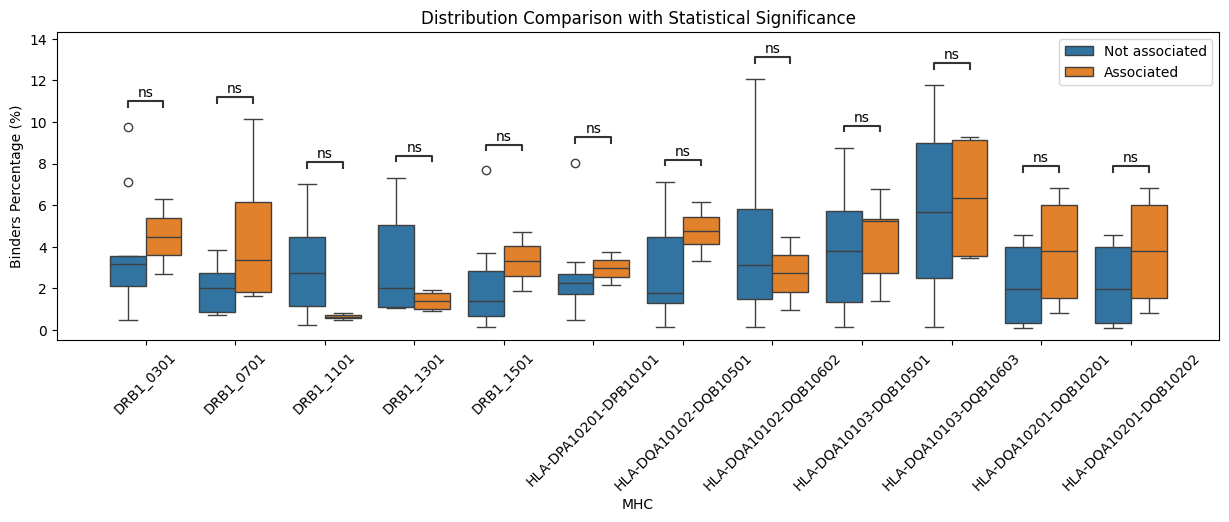

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Standardized Mean: 0.48498631838861117


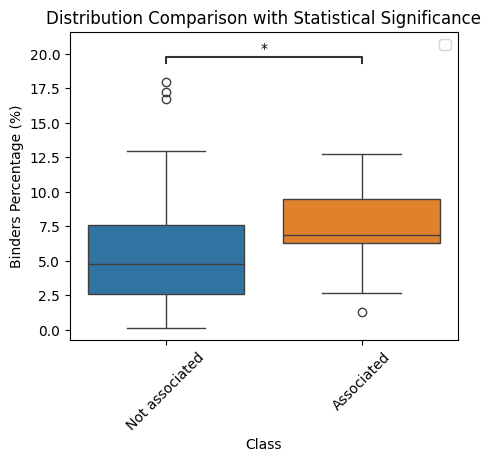

In [299]:
df_annotations_and_mapping_imputations = pd.read_csv('./Merged_HLA_imputations_Peptides_annotations.tsv', sep='\t')

internal_all_alleles_comparison, internal_summary_comparison = perform_internal_check(output_netmhciipan, df_annotations_and_mapping_imputations= df_annotations_and_mapping_imputations)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HLA-DQA10103-DQB10603_Not associated vs. HLA-DQA10103-DQB10603_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:3.286e-01 U_stat=2.000e+00
HLA-DQA10201-DQB10201_Not associated vs. HLA-DQA10201-DQB10201_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:4.000e-01 U_stat=1.000e+00
HLA-DQA10201-DQB10202_Not associated vs. HLA-DQA10201-DQB10202_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:4.000e-01 U_stat=1.000e+00
HLA-DQA10103-DQB10501_Not associated vs. HLA-DQA10103-DQB10501_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.000e-01 U_stat=1.000e+00
DRB1_0701_Not associated vs. DRB1_0701_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:6.667e-01 U_stat=1.000e+00
DRB1_0301_Not associated vs. DRB1_0301_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+

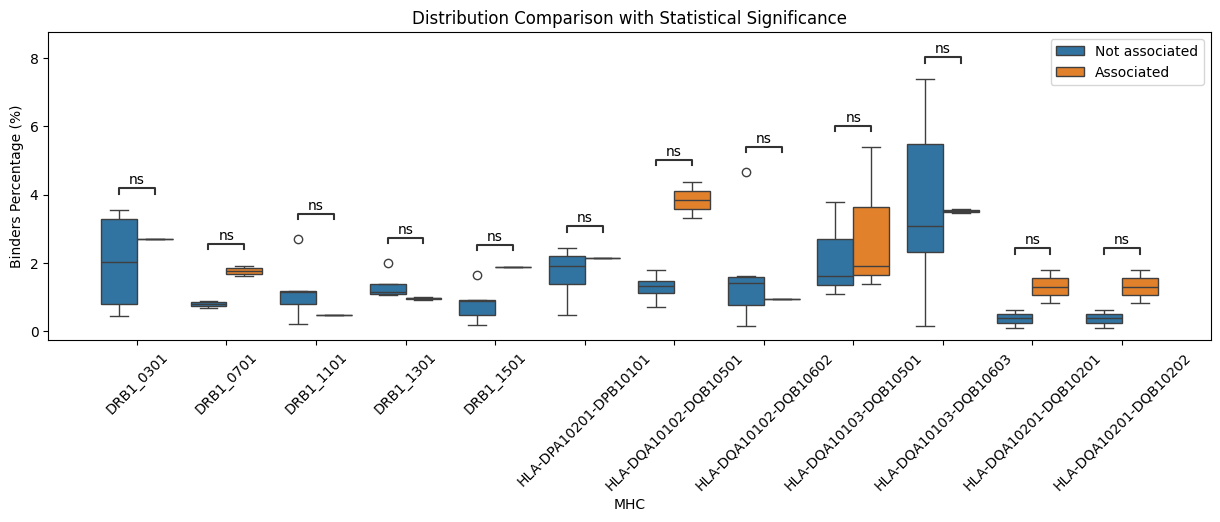

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Not associated vs. Associated: t-test independent samples, P_val:1.278e-01 t=-1.542e+00
Standardized Mean: nan


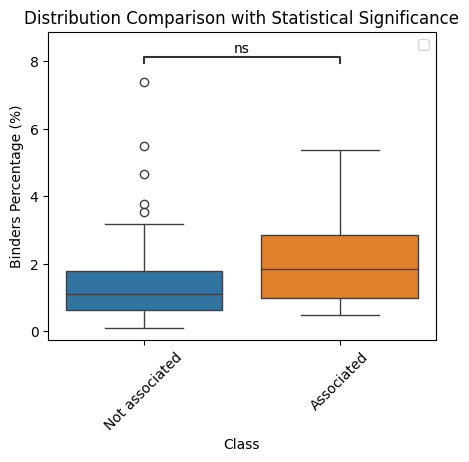

In [106]:
perform_internal_check(output_netmhciipan, df_annotations_and_mapping_imputations= df_annotations_and_mapping_imputations, binder = '<=SB')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HLA-DQA10103-DQB10603_Not associated vs. HLA-DQA10103-DQB10603_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:7.864e-02 U_stat=0.000e+00
HLA-DQA10201-DQB10201_Not associated vs. HLA-DQA10201-DQB10201_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:5.714e-01 U_stat=3.000e+00
HLA-DQA10201-DQB10202_Not associated vs. HLA-DQA10201-DQB10202_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:5.714e-01 U_stat=3.000e+00
HLA-DQA10103-DQB10501_Not associated vs. HLA-DQA10103-DQB10501_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:5.714e-02 U_stat=0.000e+00
DRB1_0701_Not associated vs. DRB1_0701_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:3.810e-01 U_stat=2.000e+00
DRB1_0301_Not associated vs. DRB1_0301_Associated: Mann-Whitney-Wilcoxon test two-sided, P_val:5.525e-

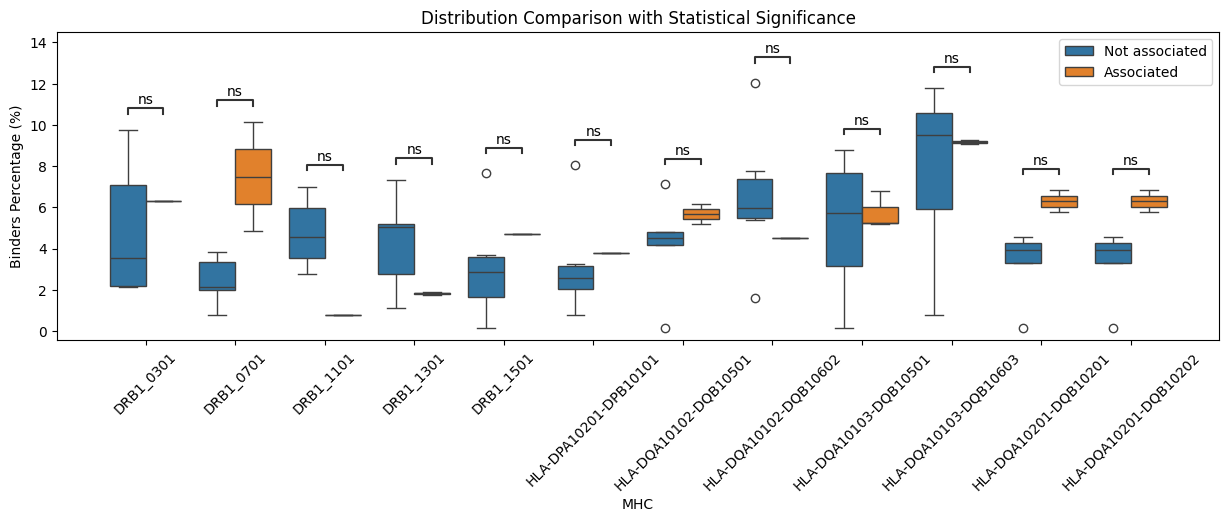

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Not associated vs. Associated: t-test independent samples, P_val:1.084e-01 t=-1.624e+00
Standardized Mean: nan


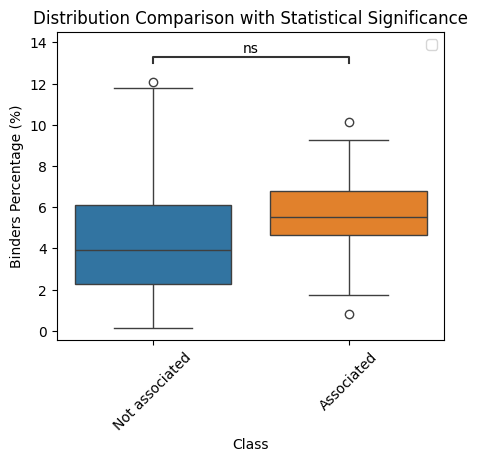

In [107]:
perform_internal_check(output_netmhciipan, df_annotations_and_mapping_imputations= df_annotations_and_mapping_imputations, binder = '<=WB')

## Workflow to compare HLA peptide binding in associated proteins vs non HLA-II associated Proteins (taken randomly from only tested set in the GWAS analysis) ###

In [91]:
output_netMHCpan_HLAassociated = '/Users/gabrielinnocenti/Desktop/phd_tmp/Projects/HLA_project_2024/HLA-II_AntibodySpecificityAssociations/data/to_analyze/formatted_summary_associated.txt'
output_netMHCpan_not_associated = '/Users/gabrielinnocenti/Desktop/phd_tmp/Projects/HLA_project_2024/HLA-II_AntibodySpecificityAssociations/data/to_analyze/formatted_summary_not_associated.txt'

def perform_external_comparison(output_netMHCpan_HLAassociated, output_netMHCpan_not_associated, binder = None, summary_table_non_associated=None):
    if summary_table_non_associated is not None:
        summary_associated = netMHC_out_to_df(output_netMHCpan_HLAassociated)
        # For saving computational power we can decide to leave out the BindLevel (use only )
        grouped_associated_binders = create_summarized_groups(summary_associated, group_on=['MHC', 'peptide_name', 'BindLevel'])
        if binder:
            grouped_associated_binders = grouped_associated_binders[grouped_associated_binders['BindLevel'] == binder]
        grouped_associated_binders['Class'] = 'proteins HLA associated'
        grouped_non_associated_binders = summary_table_non_associated
    else:
        summary_associated = netMHC_out_to_df(output_netMHCpan_HLAassociated)
        summary_not_associated = netMHC_out_to_df(output_netMHCpan_not_associated)

        # For saving computational power we can decide to leave out the BindLevel (use only )
        grouped_associated_binders = create_summarized_groups(summary_associated, group_on=['MHC', 'peptide_name', 'BindLevel'])
        if binder:
            grouped_associated_binders = grouped_associated_binders[grouped_associated_binders['BindLevel'] == binder]
        grouped_associated_binders['Class'] = 'proteins HLA associated'
        grouped_non_associated_binders = create_summarized_groups(summary_not_associated, group_on=['MHC', 'peptide_name', 'BindLevel'])
    if binder:
        grouped_non_associated_binders = grouped_non_associated_binders[grouped_non_associated_binders['BindLevel'] == binder]
    grouped_non_associated_binders['Class'] = 'proteins non HLA associated'

    groups_associated_all_binders = grouped_associated_binders.reset_index().groupby(['MHC', 'peptide_name']).sum()[['Pos']]
    groups_associated_all_binders['Size'] = grouped_associated_binders.reset_index().groupby(['MHC', 'peptide_name']).first()['Size']
    groups_associated_all_binders['Percentage'] = (groups_associated_all_binders['Pos'] / groups_associated_all_binders['Size'])*100
    groups_associated_all_binders = groups_associated_all_binders.reset_index()
    groups_associated_all_binders['Class'] ='HLA associated'


    groups_not_associated_all_binders = grouped_non_associated_binders.reset_index().groupby(['MHC', 'peptide_name']).sum()[['Pos']]
    groups_not_associated_all_binders['Size'] = grouped_non_associated_binders.reset_index().groupby(['MHC', 'peptide_name']).first()['Size']
    groups_not_associated_all_binders['Percentage'] = (groups_not_associated_all_binders['Pos'] / groups_not_associated_all_binders['Size'])*100
    groups_not_associated_all_binders = groups_not_associated_all_binders.reset_index()
    groups_not_associated_all_binders['Class'] = 'not HLA associated'

    # Summary all
    groups_associated_not_associated_all_binders = pd.concat([groups_not_associated_all_binders, groups_associated_all_binders]).reset_index()

    # All allele comparison
    df_grouped_concat_associated_not_associated = pd.concat([grouped_non_associated_binders, grouped_associated_binders]).reset_index()

    plt.figure(figsize=(18,5))
    ax = sns.boxplot(data= df_grouped_concat_associated_not_associated, x='MHC', hue='Class', y='Percentage')
    sns.stripplot(data=df_grouped_concat_associated_not_associated, x='MHC', hue='Class', y='Percentage', ax=ax, dodge=True, jitter=True, size=3, alpha=0.5, linewidth=0.5, edgecolor="gray")

    plt.xticks(rotation=90)

    create_boxplot_summary(df_grouped_concat_associated_not_associated, ax=ax, test='MW')

    plt.figure(figsize=(5,5))
    ax = sns.boxplot(data= groups_associated_not_associated_all_binders, x='Class', hue='Class', y='Percentage')

    sns.stripplot(data=groups_associated_not_associated_all_binders, x='Class', y='Percentage', color='black', size=4, alpha=0.5, jitter=True, dodge=False)

    create_boxplot_summary(df_grouped_concat_associated_not_associated, ax=ax, test='ttest', x='Class', on_group='Class')

# perform_external_comparison(output_netMHCpan_HLAassociated, output_netMHCpan_not_associated)


### For strong binders

/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_81628/2273111713.py:39: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=df_grouped_concat_associated_not_associated, x='MHC', hue='Class', y='Percentage', ax=ax, dodge=True, jitter=True, size=3, alpha=0.5, linewidth=0.5, edgecolor="gray")


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DRB1_1501_proteins non HLA associated vs. DRB1_1501_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.367e-01 U_stat=9.900e+01
HLA-DPA10201-DPB10101_proteins non HLA associated vs. HLA-DPA10201-DPB10101_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=0.000e+00
HLA-DQA10101-DQB10201_proteins non HLA associated vs. HLA-DQA10101-DQB10201_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.367e-01 U_stat=8.500e+00
HLA-DQA10101-DQB10302_proteins non HLA associated vs. HLA-DQA10101-DQB10302_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=3.500e+00
HLA-DQA10101-DQB10501_proteins non HLA associated vs. HLA-DQA10101-DQB10501_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val

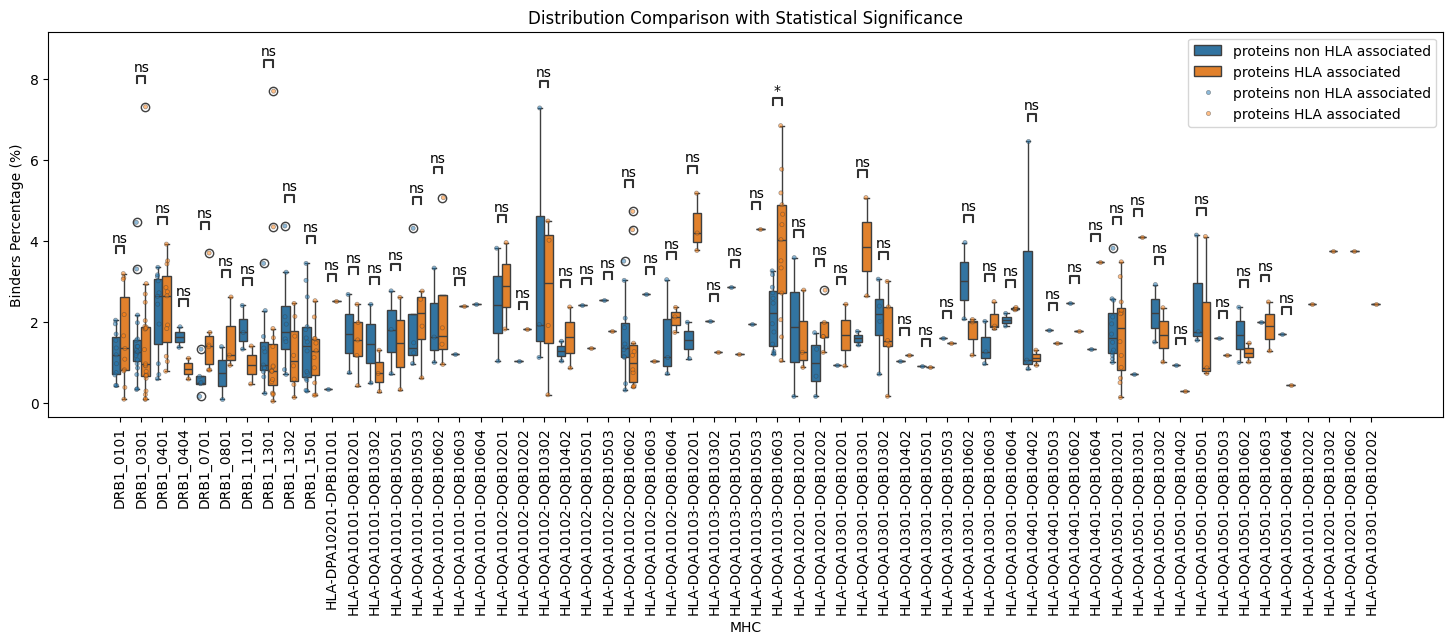

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proteins non HLA associated vs. proteins HLA associated: t-test independent samples, P_val:1.898e-01 t=-1.313e+00
Standardized Mean: nan


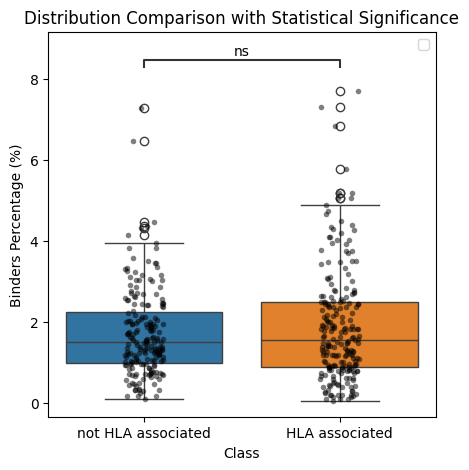

In [83]:
perform_external_comparison(output_netMHCpan_HLAassociated, output_netMHCpan_not_associated, binder = '<=SB')


### For weak binders


/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_81628/2273111713.py:39: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=df_grouped_concat_associated_not_associated, x='MHC', hue='Class', y='Percentage', ax=ax, dodge=True, jitter=True, size=3, alpha=0.5, linewidth=0.5, edgecolor="gray")


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DRB1_1501_proteins non HLA associated vs. DRB1_1501_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.402e-01 U_stat=1.670e+02
HLA-DPA10201-DPB10101_proteins non HLA associated vs. HLA-DPA10201-DPB10101_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=1.000e+00
HLA-DQA10101-DQB10201_proteins non HLA associated vs. HLA-DQA10101-DQB10201_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:4.206e-01 U_stat=8.000e+00
HLA-DQA10101-DQB10202_proteins non HLA associated vs. HLA-DQA10101-DQB10202_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=0.000e+00
HLA-DQA10101-DQB10302_proteins non HLA associated vs. HLA-DQA10101-DQB10302_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val

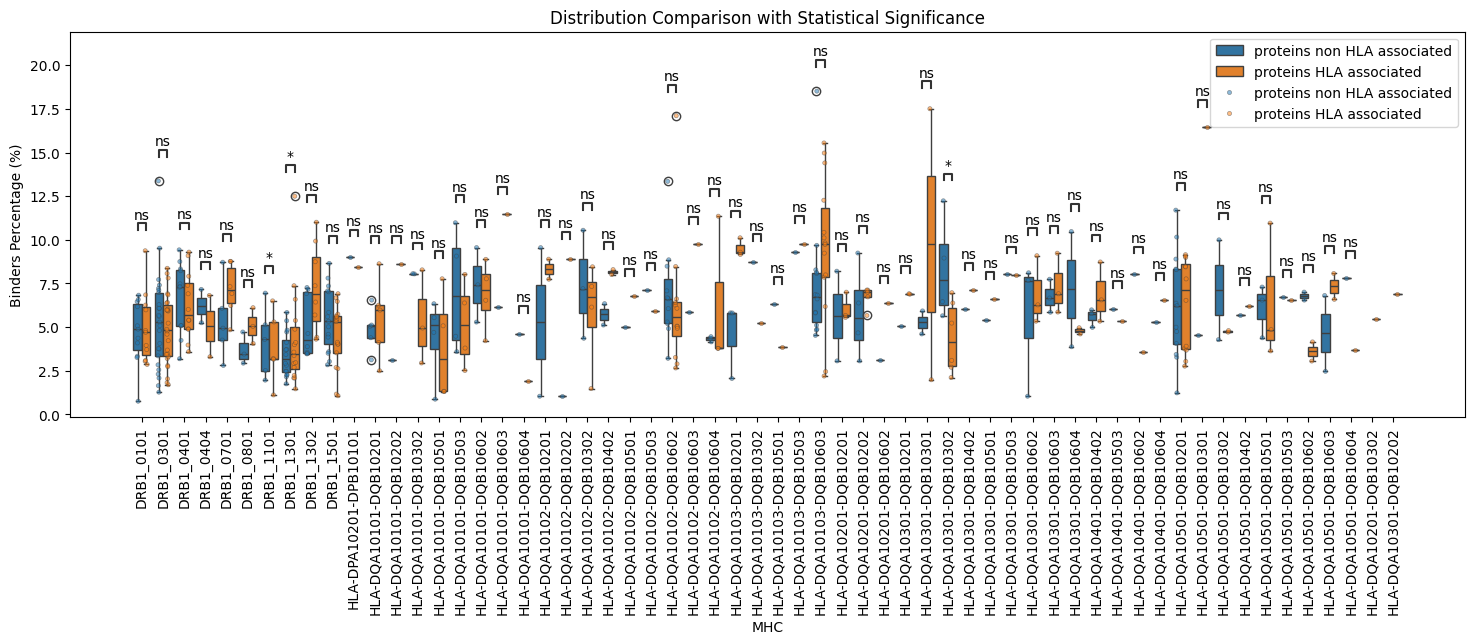

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proteins non HLA associated vs. proteins HLA associated: t-test independent samples, P_val:2.265e-01 t=-1.211e+00
Standardized Mean: nan


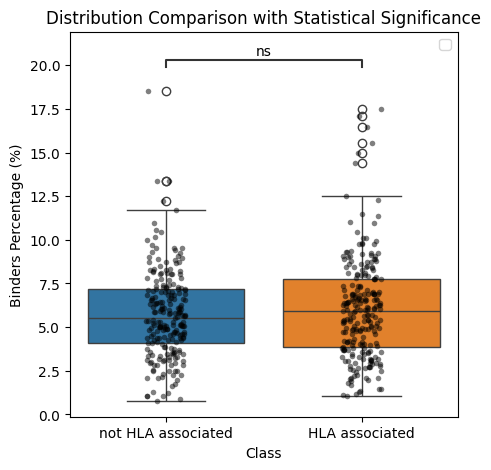

In [84]:
perform_external_comparison(output_netMHCpan_HLAassociated, output_netMHCpan_not_associated, binder = '<=WB')

## Using the method in which I compare the associated proteins binding vs all possible combinations of non associated proteins and the associated alleles.

In [87]:
# Load directly the summary table for non_associated all combinations
table_not_associated_all_comb = pd.read_csv('/Users/gabrielinnocenti/Desktop/phd_tmp/Projects/HLA_project_2024/HLA-II_AntibodySpecificityAssociations/NetMHCII-predictions/grouped_values_all_combinations_proteins_non_associated_with_HLA_alleles_associated.tsv', sep = '\t')

/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_81628/854392341.py:48: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=df_grouped_concat_associated_not_associated, x='MHC', hue='Class', y='Percentage', ax=ax, dodge=True, jitter=True, size=3, alpha=0.5, linewidth=0.5, edgecolor="gray")


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DRB1_1501_proteins non HLA associated vs. DRB1_1501_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.500e-01 U_stat=2.372e+03
HLA-DPA10201-DPB10101_proteins non HLA associated vs. HLA-DPA10201-DPB10101_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:4.245e-01 U_stat=1.035e+02
HLA-DQA10101-DQB10201_proteins non HLA associated vs. HLA-DQA10101-DQB10201_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:4.123e-01 U_stat=6.800e+02
HLA-DQA10101-DQB10202_proteins non HLA associated vs. HLA-DQA10101-DQB10202_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.277e-01 U_stat=5.950e+01
HLA-DQA10101-DQB10302_proteins non HLA associated vs. HLA-DQA10101-DQB10302_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val

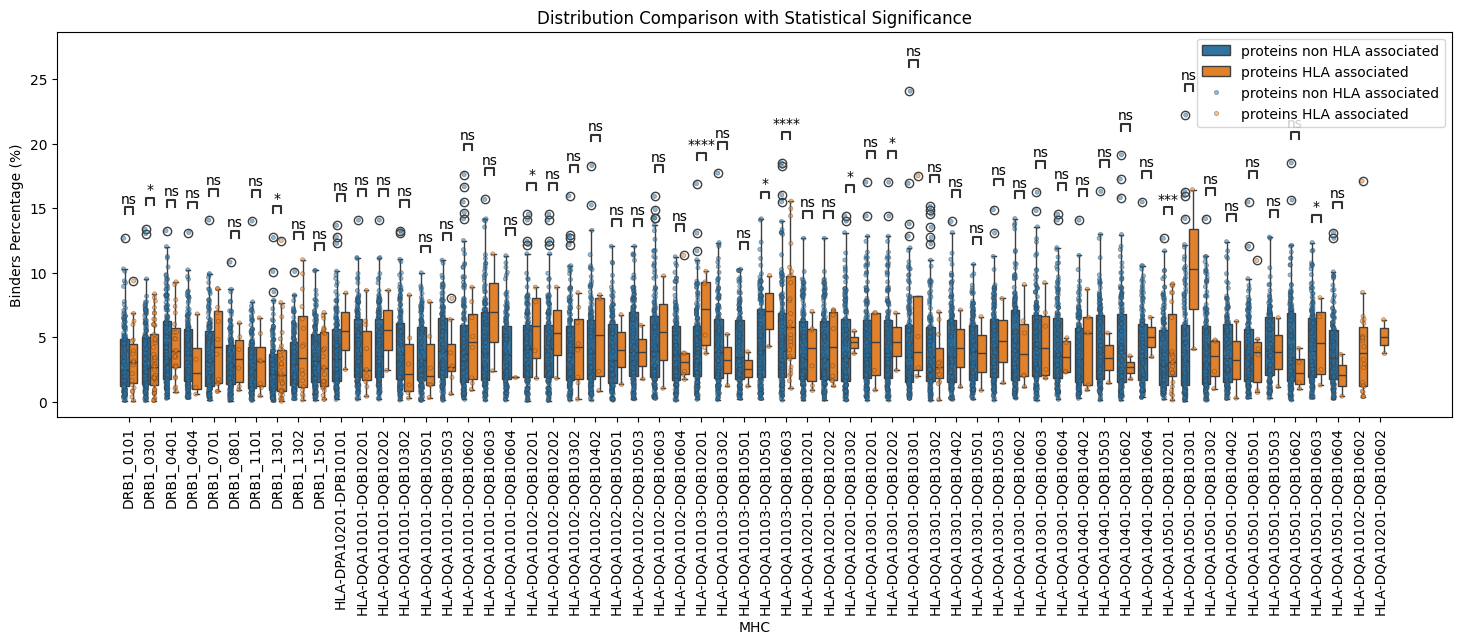

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proteins non HLA associated vs. proteins HLA associated: t-test independent samples, P_val:7.756e-01 t=2.850e-01
Standardized Mean: nan


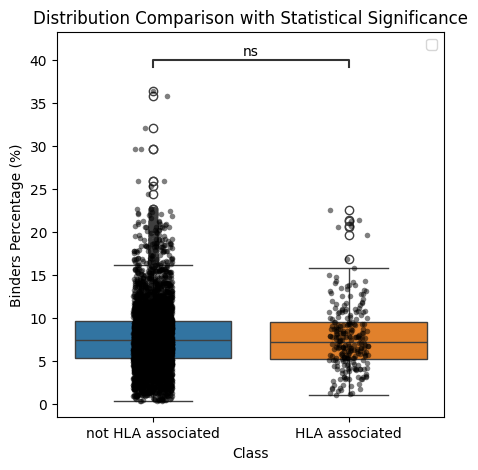

In [92]:
perform_external_comparison(output_netMHCpan_HLAassociated, output_netMHCpan_not_associated=None, summary_table_non_associated=table_not_associated_all_comb)


### Strong binders

/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_81628/854392341.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_non_associated_binders['Class'] = 'proteins non HLA associated'
/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_81628/854392341.py:48: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=df_grouped_concat_associated_not_associated, x='MHC', hue='Class', y='Percentage', ax=ax, dodge=True, jitter=True, size=3, alpha=0.5, linewidth=0.5, edgecolor="gray")


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HLA-DQA10101-DQB10302_proteins non HLA associated vs. HLA-DQA10101-DQB10302_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:9.585e-01 U_stat=1.150e+02
HLA-DQA10101-DQB10501_proteins non HLA associated vs. HLA-DQA10101-DQB10501_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:9.710e-01 U_stat=6.450e+01
HLA-DQA10101-DQB10503_proteins non HLA associated vs. HLA-DQA10101-DQB10503_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:6.153e-01 U_stat=1.185e+02
HLA-DQA10101-DQB10602_proteins non HLA associated vs. HLA-DQA10101-DQB10602_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:5.142e-01 U_stat=1.285e+02
HLA-DQA10101-DQB10603_proteins non HLA associated vs. HLA-DQA10101-DQB10603_proteins HLA associated: Mann-Whitney-Wilcox

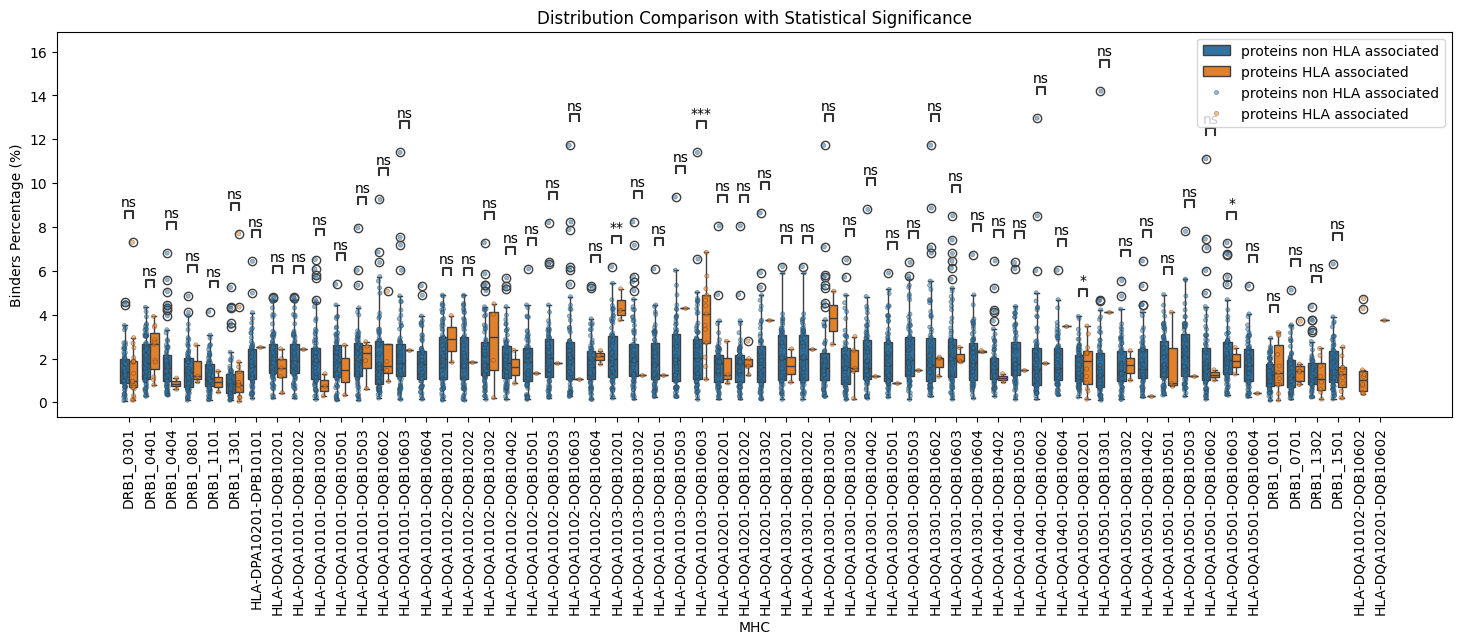

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proteins non HLA associated vs. proteins HLA associated: t-test independent samples, P_val:5.685e-01 t=5.704e-01
Standardized Mean: nan


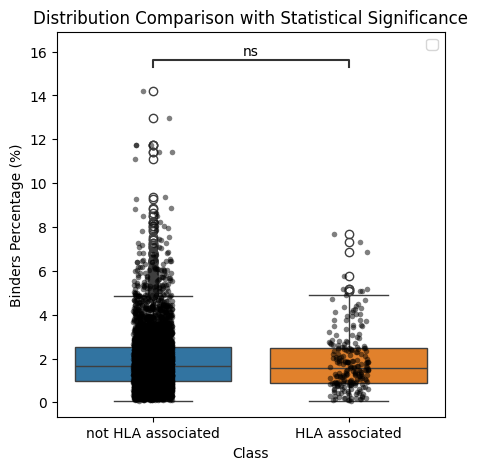

In [93]:
perform_external_comparison(output_netMHCpan_HLAassociated, output_netMHCpan_not_associated=None, summary_table_non_associated=table_not_associated_all_comb, binder='<=SB')


### Weak binders

/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_81628/854392341.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_non_associated_binders['Class'] = 'proteins non HLA associated'
/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_81628/854392341.py:48: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=df_grouped_concat_associated_not_associated, x='MHC', hue='Class', y='Percentage', ax=ax, dodge=True, jitter=True, size=3, alpha=0.5, linewidth=0.5, edgecolor="gray")


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DRB1_1501_proteins non HLA associated vs. DRB1_1501_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.984e-01 U_stat=8.160e+02
HLA-DPA10201-DPB10101_proteins non HLA associated vs. HLA-DPA10201-DPB10101_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:4.211e-01 U_stat=2.150e+01
HLA-DQA10101-DQB10201_proteins non HLA associated vs. HLA-DQA10101-DQB10201_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:3.495e-01 U_stat=1.570e+02
HLA-DQA10101-DQB10202_proteins non HLA associated vs. HLA-DQA10101-DQB10202_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.367e-01 U_stat=5.000e+00
HLA-DQA10101-DQB10302_proteins non HLA associated vs. HLA-DQA10101-DQB10302_proteins HLA associated: Mann-Whitney-Wilcoxon test two-sided, P_val

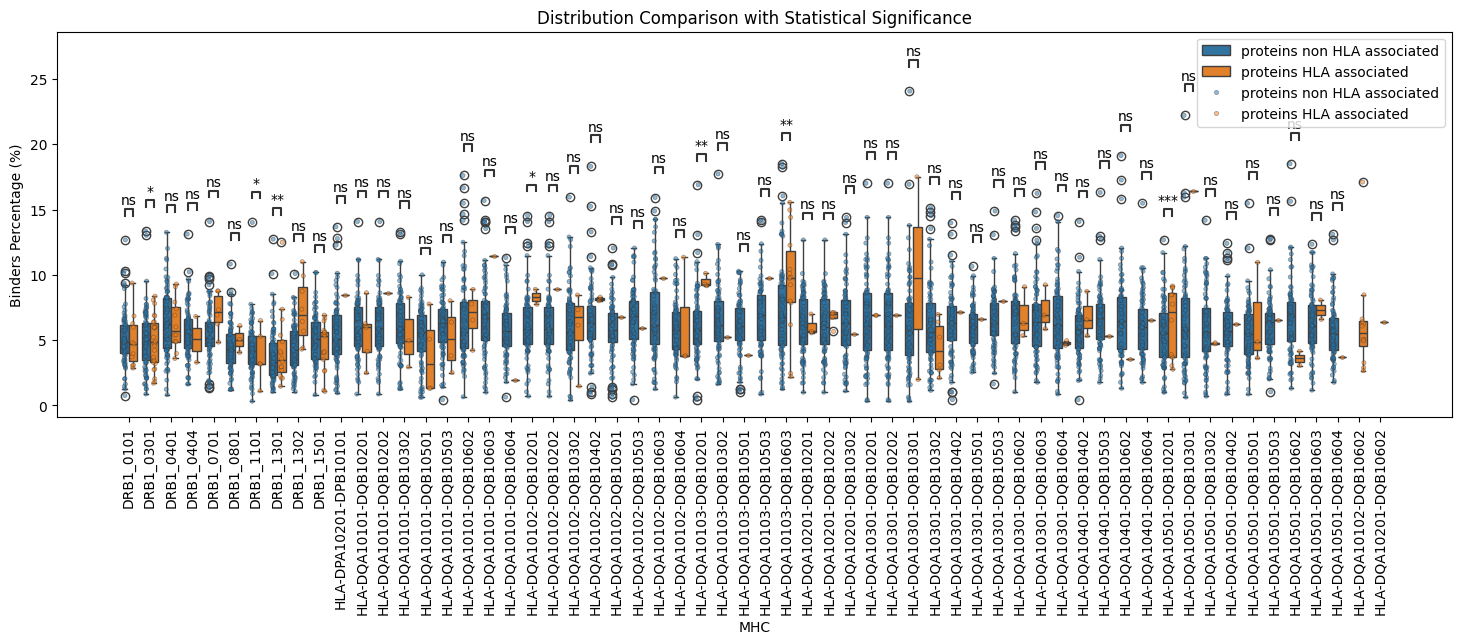

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

proteins non HLA associated vs. proteins HLA associated: t-test independent samples, P_val:9.619e-01 t=-4.776e-02
Standardized Mean: nan


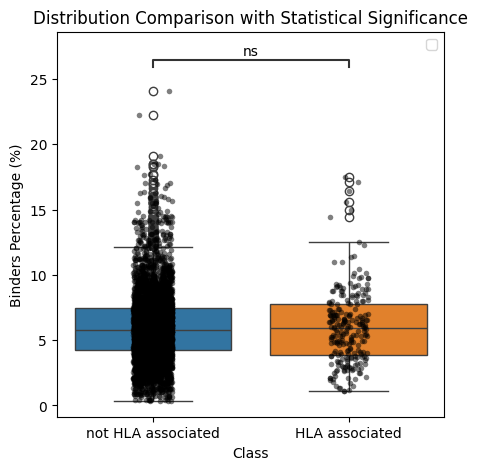

In [94]:
perform_external_comparison(output_netMHCpan_HLAassociated, output_netMHCpan_not_associated=None, summary_table_non_associated=table_not_associated_all_comb, binder='<=WB')


## %Rank_EL Score and EL_score: the proportion of high level EL score on the total is higher in associated proteins or non-associated?
EL_score levels >0.99, >0.98, >0.95, >0.90...>0.80

In [187]:
output_non_associated_binders_all_combinations = '/Users/gabrielinnocenti/Desktop/phd_tmp/Projects/HLA_project_2024/HLA-II_AntibodySpecificityAssociations/data/to_analyze/formatted_results_combinatorial_analysis_not_associated_proteins.txt'
output_netMHCpan_HLAassociated = '/Users/gabrielinnocenti/Desktop/phd_tmp/Projects/HLA_project_2024/HLA-II_AntibodySpecificityAssociations/data/to_analyze/formatted_summary_associated.txt'
output_netMHCpan_not_associated = '/Users/gabrielinnocenti/Desktop/phd_tmp/Projects/HLA_project_2024/HLA-II_AntibodySpecificityAssociations/data/to_analyze/formatted_summary_not_associated.txt'

summary_non_associated_binders_all_combinations = netMHC_out_to_df(output_non_associated_binders_all_combinations)
summary_associated = netMHC_out_to_df(output_netMHCpan_HLAassociated)
summary_not_associated = netMHC_out_to_df(output_netMHCpan_not_associated)


In [179]:
output_netMHCpan_HLAassociated = '/Users/gabrielinnocenti/Desktop/phd_tmp/Projects/HLA_project_2024/HLA-II_AntibodySpecificityAssociations/data/to_analyze/formatted_summary_associated.txt'
output_netMHCpan_not_associated = '/Users/gabrielinnocenti/Desktop/phd_tmp/Projects/HLA_project_2024/HLA-II_AntibodySpecificityAssociations/data/to_analyze/formatted_summary_not_associated.txt'

summary_associated = netMHC_out_to_df(output_netMHCpan_HLAassociated)
summary_not_associated = netMHC_out_to_df(output_netMHCpan_not_associated)
summary_not_associated['Score_EL'] = summary_not_associated['Score_EL'].astype(float)

sns.histplot(data=summary_not_associated[summary_not_associated['Score_EL'] >=0.6], x='Score_EL', bins=100, color='tab:red', label='Not associated',alpha=.4, kde=True)

sns.histplot(data=summary_associated[summary_associated['Score_EL'] >= 0.6], x='Score_EL', bins=100, color='tab:green', label='Associated', alpha=.4, kde=True)

In [262]:
out_only_elisa = netMHC_out_to_df(output_netmhciipan, method=2) # internal_all_alleles_comparison
# deduplicated_internal_control= internal_all_alleles_comparison[['MHC', 'peptide_name', 'Class']].drop_duplicates()


# df_grouped_slid_wind_reidx = df1.reset_index()
list_HLA = []
list_associations = []
for prot,allele in out_only_elisa[['peptide_name', 'MHC']].values:
    if 'DRB' not in allele:
        allele_A = allele.split('-')[1]
        allele_B = allele.split('-')[2]
        allele_HLA_A = f'HLA_{allele_A[:4]}_{allele_A[4:]}'
        allele_HLA_B = f'HLA_{allele_B[:4]}_{allele_B[4:]}'
        # print(allele_HLA_A)
        len_df_both_alleles = len(df_annotations_and_mapping_imputations[(df_annotations_and_mapping_imputations['prot_num'] == prot) & \
                                                        (df_annotations_and_mapping_imputations['Variant'] == allele_HLA_A)]) + \
                                                        len(df_annotations_and_mapping_imputations[(df_annotations_and_mapping_imputations['prot_num'] == prot) & \
                                                        (df_annotations_and_mapping_imputations['Variant'] == allele_HLA_B)])
        # print(f'Found matches to {allele}: {len_df_both_alleles}')
        if len_df_both_alleles != 0:
            list_HLA.append((prot,[allele_HLA_A, allele_HLA_B]))
            list_associations.append('Associated')
        else:
            list_associations.append('Not associated')
    else:
        allele_HLA = f'HLA_{allele}'
        len_df_allele_DRB = len(df_annotations_and_mapping_imputations[(df_annotations_and_mapping_imputations['prot_num'] == prot) & \
                                                        (df_annotations_and_mapping_imputations['Variant'] == allele_HLA)])
        # print(f'Found matches to {allele}: {len_df_allele_DRB}')
        if len_df_allele_DRB != 0:
            list_HLA.append((prot,[allele]))
            list_associations.append('Associated')
        else:
            list_associations.append('Not associated')


out_only_elisa['Class'] = list_associations
# out_only_elisa_annot = pd.merge(out_only_elisa, deduplicated_internal_control[['MHC', 'peptide_name', 'Class']], on=['peptide_name', 'MHC'], how='left')


0.29880478087649404
0.2609010126059103


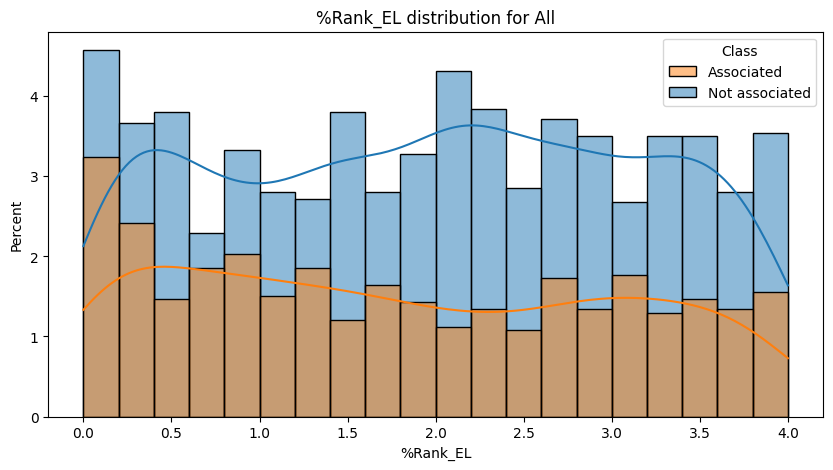

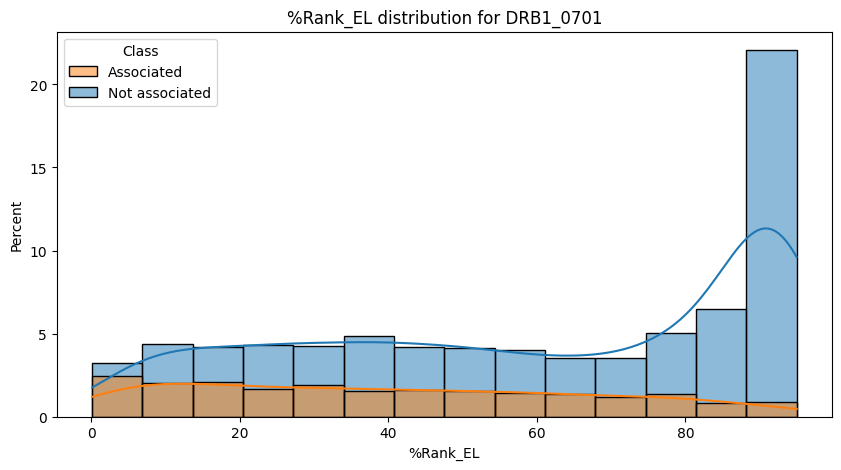

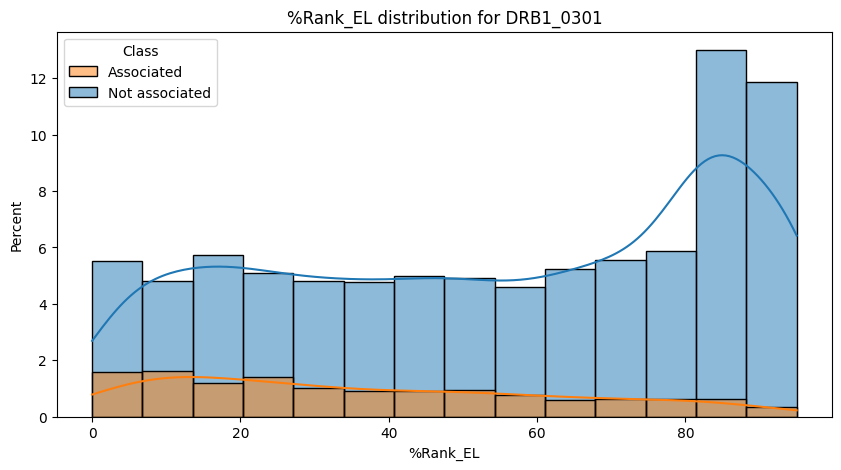

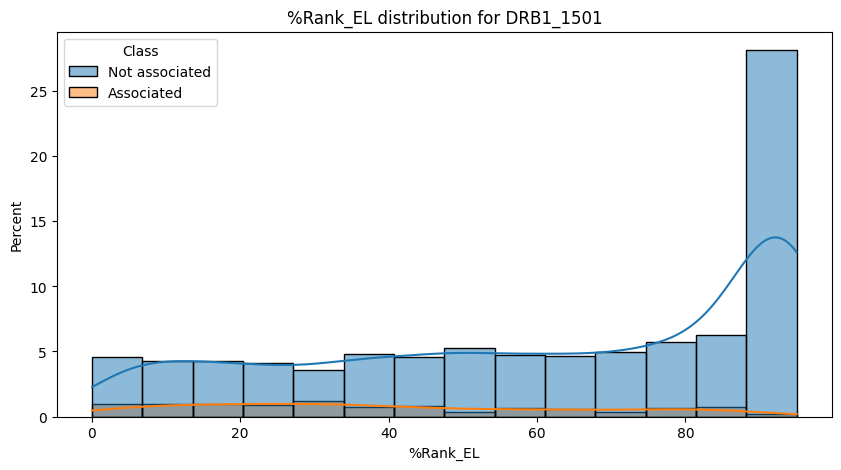

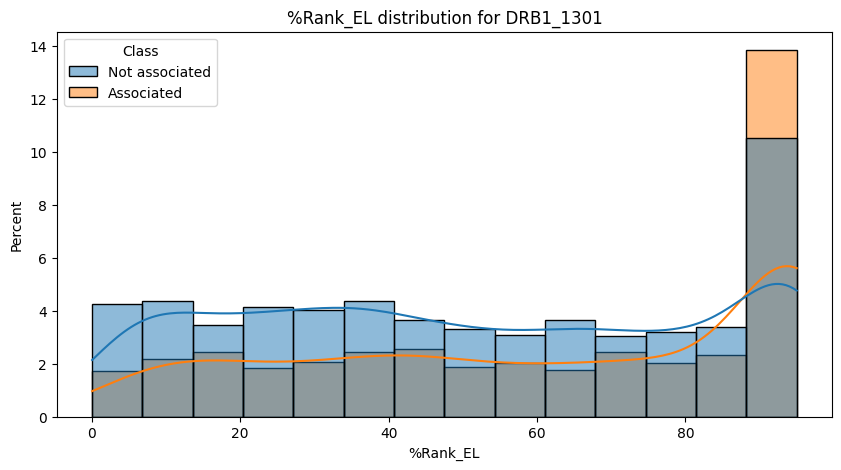

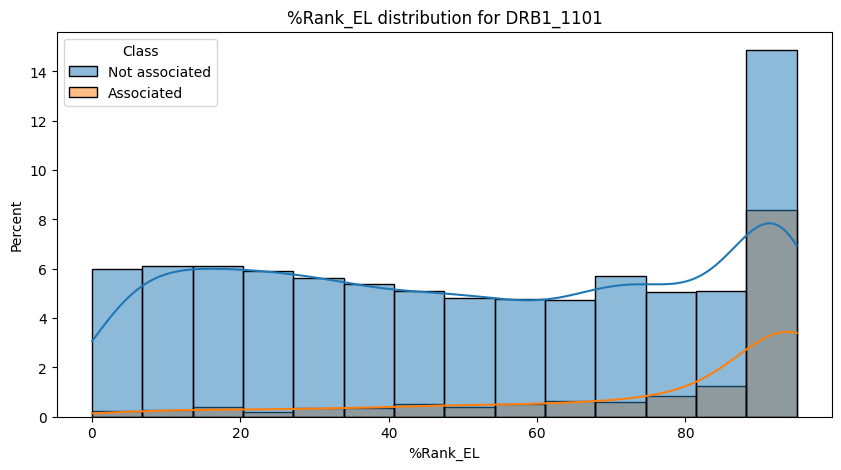

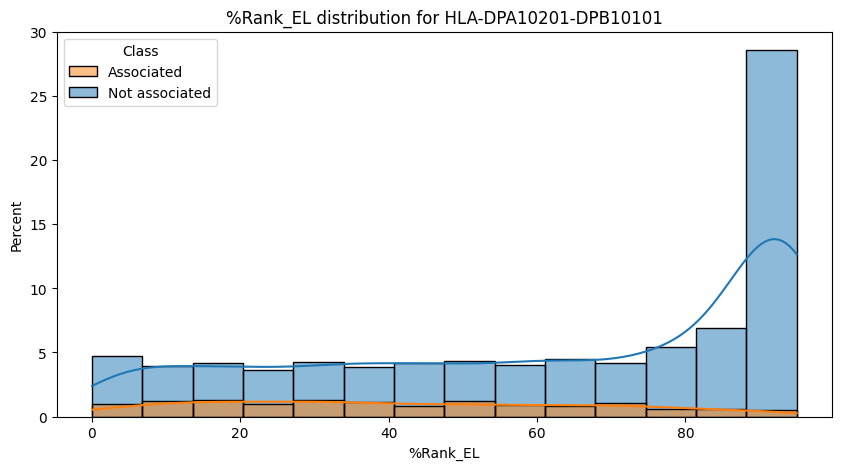

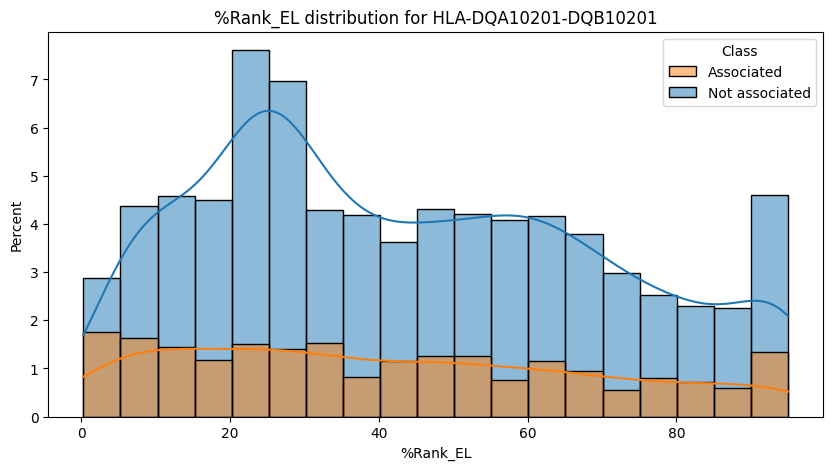

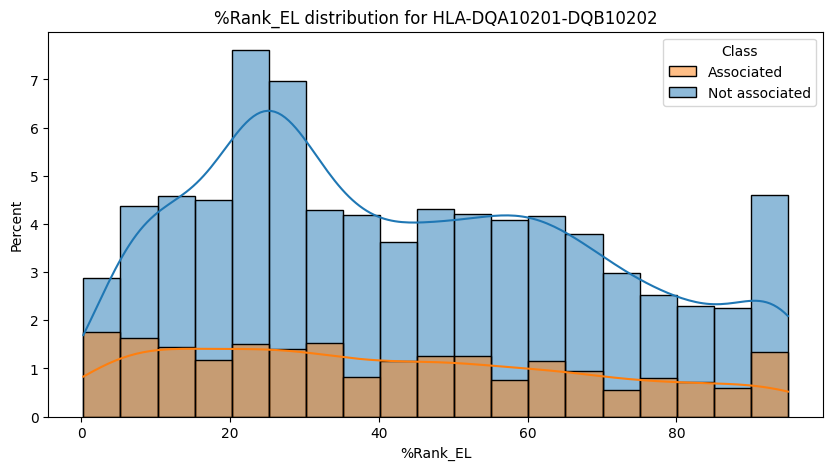

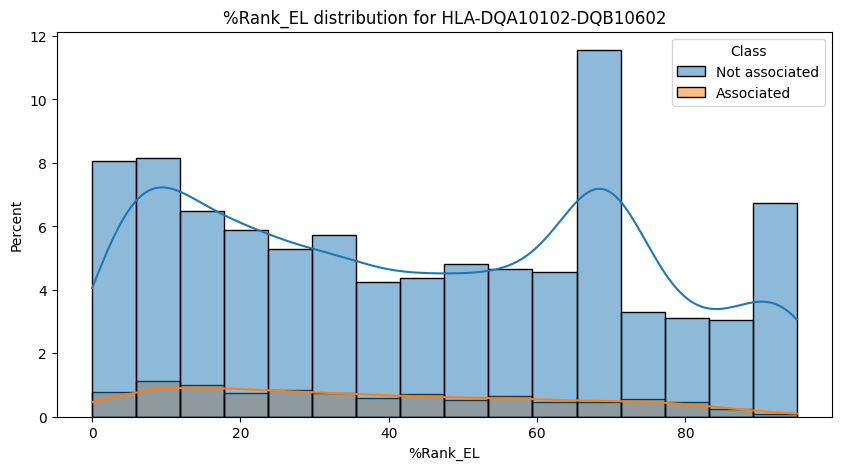

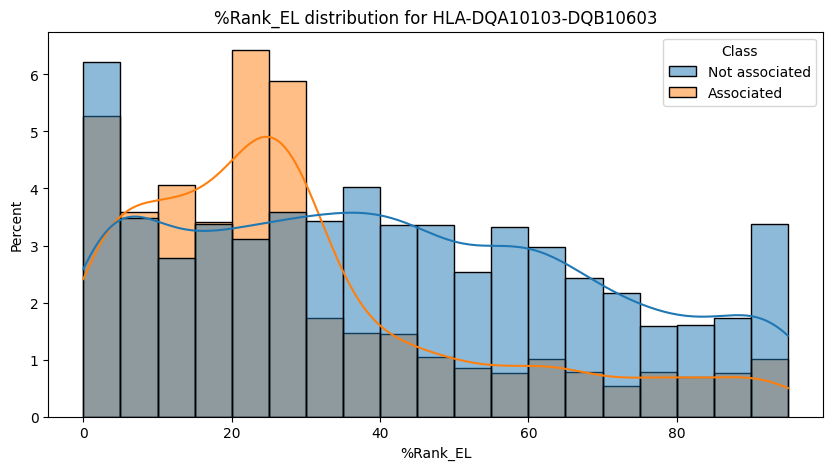

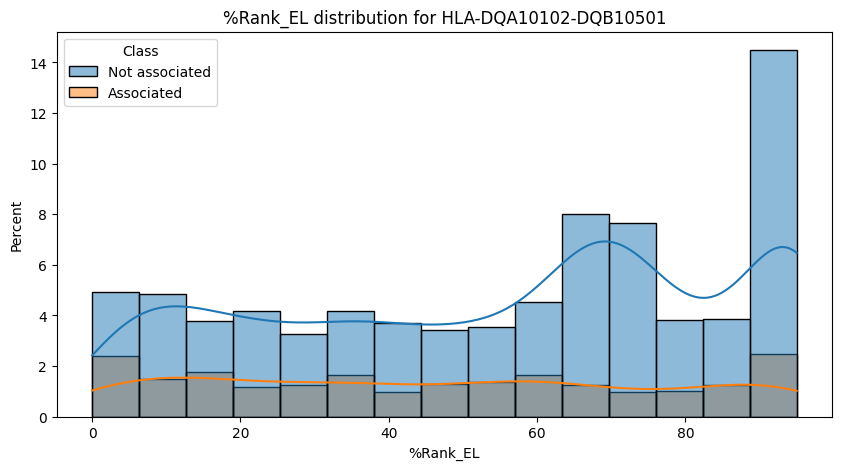

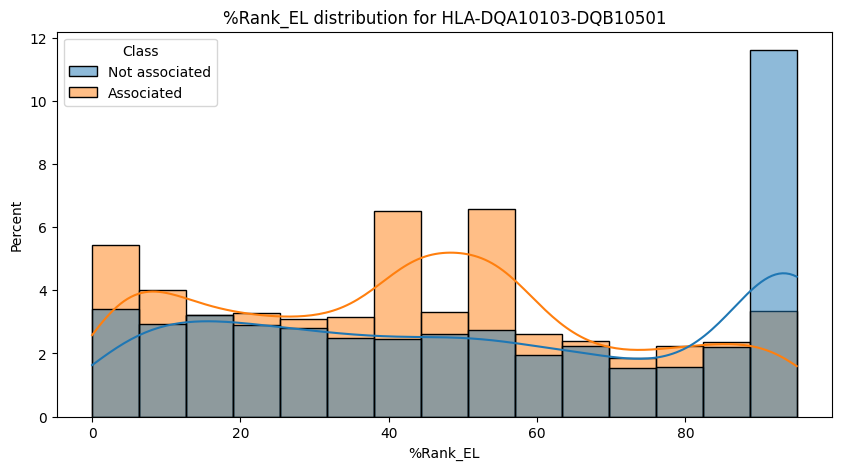

In [323]:
out_only_elisa['%Rank_EL'] = out_only_elisa['%Rank_EL'] .astype(float)
# Define custom colors for hue categories
custom_palette = {"Associated": "tab:orange", "Not associated": "tab:blue"}
plt.figure(figsize=(10,5))
sns.histplot(data=out_only_elisa[out_only_elisa['%Rank_EL']<=4], x='%Rank_EL', kde=True, hue='Class', stat='percent', palette=custom_palette, bins=20)
plt.title(f'%Rank_EL distribution for All')
for allele in out_only_elisa['MHC'].unique():
    out_only_elisa_allele = out_only_elisa[out_only_elisa['MHC'] == allele]
    plt.figure(figsize=(10,5))
    sns.histplot(data=out_only_elisa_allele, x='%Rank_EL', kde=True, hue='Class', stat='percent', palette=custom_palette)
    plt.title(f'%Rank_EL distribution for {allele}')
len(out_only_elisa[(out_only_elisa['%Rank_EL'] <=5) & (out_only_elisa['Class'] =='Associated')]) / len(out_only_elisa) * 100


print(len(out_only_elisa[(out_only_elisa['MHC'] == 'DRB1_0701') & (out_only_elisa['peptide_name'] == 'prot_16932') & (out_only_elisa['BindLevel'].notnull())]) / len(out_only_elisa[(out_only_elisa['Class'] == 'Associated')]) * 100)

print(len(out_only_elisa[(out_only_elisa['MHC'] == 'DRB1_0701') & (out_only_elisa['Class'] == 'Not associated') & (out_only_elisa['BindLevel'].notnull())]) / len(out_only_elisa[(out_only_elisa['Class'] == 'Not associated')]) * 100)

In [ ]:
print((len(out_only_elisa[(out_only_elisa['Class'] == 'Associated') & (out_only_elisa['%Rank_EL'] <= 1)]) / len(out_only_elisa[(out_only_elisa['Class'] == 'Associated')])) * 100)
print((len(out_only_elisa[(out_only_elisa['Class'] == 'Not associated') & (out_only_elisa['%Rank_EL'] <= 1)]) / len(out_only_elisa[(out_only_elisa['Class'] == 'Not associated')])) * 100)

plt.figure(figsize=(10,5))
sns.histplot(data=out_only_elisa[(out_only_elisa['%Rank_EL']<=2) & (out_only_elisa['Class'] == 'Associated')], x='%Rank_EL', kde=True, stat='percent', bins=20)
plt.title(f'%Rank_EL distribution for All')
len(out_only_elisa[(out_only_elisa['%Rank_EL'] <=1) & (out_only_elisa['Class'] =='Associated')]) / len(out_only_elisa) * 100

2.1165338645418323
1.0642694771647034


0.5023640661938534

<Axes: xlabel='%Rank_EL', ylabel='Percent'>

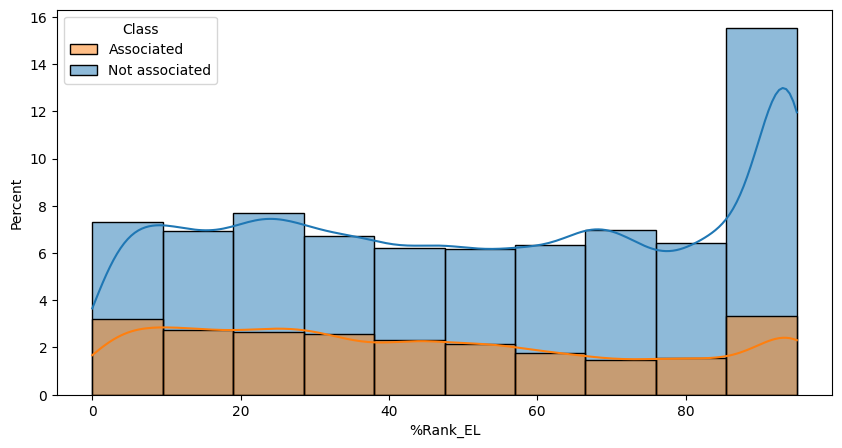

In [457]:
out_only_elisa['%Rank_EL'] = out_only_elisa['%Rank_EL'] .astype(float)
# Define custom colors for hue categories
custom_palette = {"Associated": "tab:orange", "Not associated": "tab:blue"}
plt.figure(figsize=(10,5))
sns.histplot(data=out_only_elisa[out_only_elisa['%Rank_EL']<=100], x='%Rank_EL', kde=True, hue='Class', stat='percent', palette=custom_palette, bins=10)


In [545]:


def plot_rank_distribution_in_percentage(df_associated, df_not_associated, bins=10, loc='upper right'):
    import matplotlib.patches as mpatches
    from matplotlib.lines import Line2D
    plt.figure(figsize=(10,5))
    df_associated['%Rank_EL'] = df_associated['%Rank_EL'].astype(float)
    df_not_associated['%Rank_EL'] = df_not_associated['%Rank_EL'].astype(float)

    sns.histplot(data=df_associated[df_associated['%Rank_EL']<=100], x='%Rank_EL', kde=True, hue='Class', stat='percent', palette=custom_palette, bins=bins, label='Associated')
    plt.title(f'%Rank_EL distribution for All')
    plt.legend()

    # plt.figure(figsize=(10,5))
    sns.histplot(data=df_not_associated[(df_not_associated['%Rank_EL']<=100)], x='%Rank_EL', kde=True, stat='percent', hue='Class', palette=custom_palette, bins=bins, label='Not associated')
    plt.title(f'%Rank_EL distribution for All')
    # Add vertical lines
    plt.axvline(x=5., color='grey', label='Weak binders', ls='--')
    plt.axvline(x=1., color='red', label='Strong binders')

    # Manually create a shared legend
    legend_patches_and_lines = [
        mpatches.Patch(color=custom_palette["Associated"], label="Associated"),
        mpatches.Patch(color=custom_palette["Not associated"], label="Not associated"),
        Line2D([0], [0], color='grey', lw=2, ls='--', label='Weak binders'),
        Line2D([0], [0], color='red', lw=2, label='Strong binders')
    ]

    plt.legend(handles=legend_patches_and_lines, title="Class", loc=loc)
# sns.histplot(data=out_only_elisa[(out_only_elisa['%Rank_EL']<=1) & (out_only_elisa['Class'] == 'Not associated')], x='%Rank_EL', kde=True, stat='percent', hue='Class', palette=custom_palette, bins=1)
# plt.title(f'%Rank_EL distribution for All')


/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_81628/853898408.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_associated['%Rank_EL'] = df_associated['%Rank_EL'].astype(float)
/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_81628/853898408.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_associated['%Rank_EL'] = df_not_associated['%Rank_EL'].astype(float)


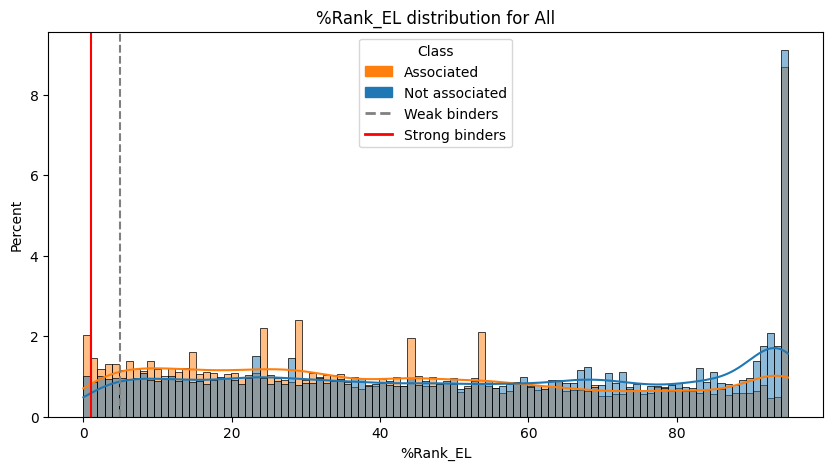

In [547]:

out_only_elisa_associated = out_only_elisa[out_only_elisa['Class'] == 'Associated']
out_only_elisa_not_associated = out_only_elisa[out_only_elisa['Class'] == 'Not associated']
plot_rank_distribution_in_percentage(out_only_elisa_associated, out_only_elisa_not_associated, bins=100, loc='best')

# plt.axvline(x=5.,color='grey', label='Weak binders')
# plt.axvline(x=1.,color='red', label='Strong binders')
# # Create custom legend handles
# legend_elements = [
#     Line2D([0], [0], color='grey', lw=2, label='Weak binders'),
#     Line2D([0], [0], color='red', lw=2, label='Strong binders')
# ]

# Add the legend
# plt.legend(handles=legend_elements, loc='upper center')

/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_81628/2298379615.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_associated['%Rank_EL'] = df_associated['%Rank_EL'].astype(float)
/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_81628/2298379615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_associated['%Rank_EL'] = df_not_associated['%Rank_EL'].astype(float)


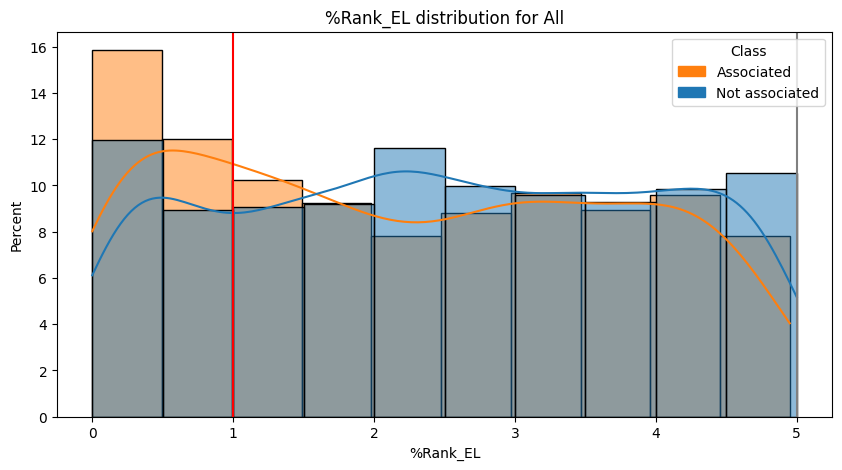

In [496]:

out_only_elisa_associated_bind = out_only_elisa_associated[out_only_elisa_associated['%Rank_EL'] <=5]
out_only_elisa_not_associated_bind = out_only_elisa_not_associated[out_only_elisa_not_associated['%Rank_EL'] <=5]
plot_rank_distribution_in_percentage(out_only_elisa_associated_bind, out_only_elisa_not_associated_bind, bins=10, loc='upper right')
plt.axvline(x=5.,color='grey')
plt.axvline(x=1.,color='red')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Associated vs. Not associated: Mann-Whitney-Wilcoxon test two-sided, P_val:3.565e-05 U_stat=8.021e+05


(<Axes: xlabel='Class', ylabel='%Rank_EL'>,
 [<statannotations.Annotation.Annotation at 0x300e65d50>])

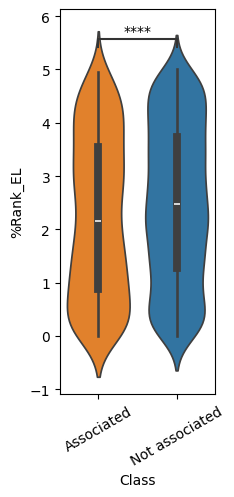

In [535]:
df_test = out_only_elisa[out_only_elisa['%Rank_EL'] <= 5]
plt.figure(figsize=(2,5))
# ax =sns.boxplot(data=df_test, x='Class', y='%Rank_EL', hue='Class')

ax =sns.violinplot(data=df_test, x='Class', y='%Rank_EL', hue='Class', hue_order=['Not associated', 'Associated'])
plt.xticks(rotation=30)

# Get unique class names
classes = df_test['Class'].unique()
pair = [(classes[0], classes[1])]

# Run the t-test
data1 = df_test[df_test['Class'] == classes[0]]['%Rank_EL']
data2 = df_test[df_test['Class'] == classes[1]]['%Rank_EL']
# stat, pval = ttest_ind(data1, data2, equal_var=False)

# Add significance annotation
annotator = Annotator(ax, pair, data=df_test, x='Class', y='%Rank_EL')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=1)
annotator.apply_and_annotate()
# mean_x1 = np.mean(df_test[df_test['Class'] == 'Associated']['Pos']) 
# mean_x2 = np.mean(df_test[df_test['Class'] == 'Not associated']['Pos'])
# numerator = mean_x1 - mean_x2
# denominator = np.sqrt(np.var(df_test[df_test['Class'] == 'Associated']['Pos']) +\
#         np.var(df_test[df_test['Class'] == 'Not associated']['Pos'])/2)
# smd = numerator / denominator
# print(f'Standardized Mean: {smd}')

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, '−20'),
  Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100'),
  Text(120.0, 0, '120')])

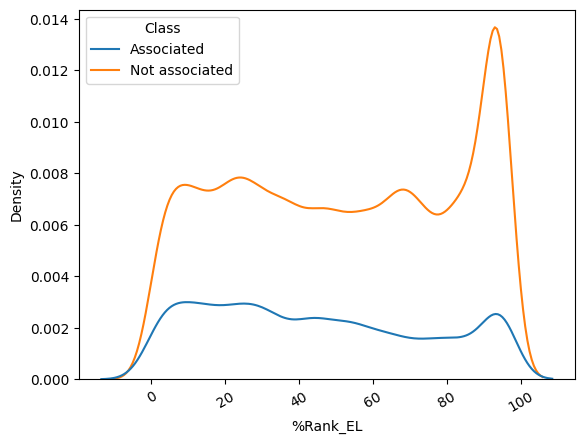

In [525]:
ax =sns.kdeplot(data=out_only_elisa, x='%Rank_EL', hue='Class')
plt.xticks(rotation=30)


In [ ]:
ss

(<Axes: xlabel='Class', ylabel='%Rank_EL'>,
 [<statannotations.Annotation.Annotation at 0x337bf24d0>])

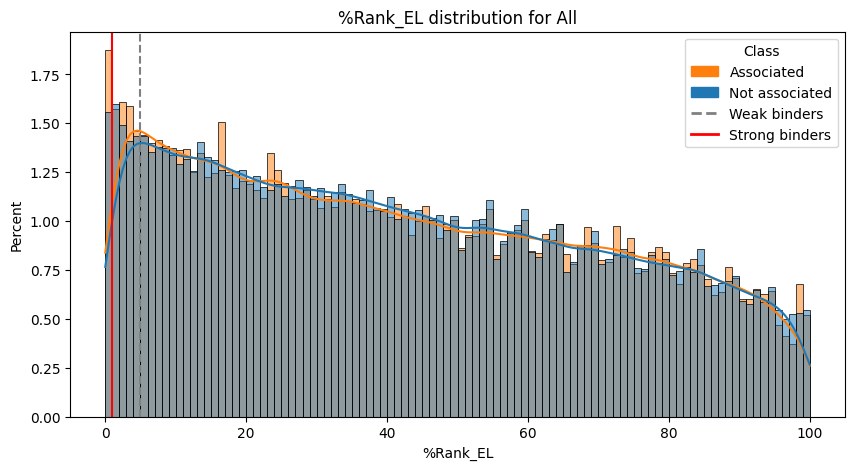

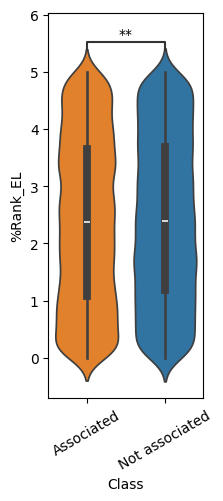

In [554]:
summary_associated['Class'] = 'Associated'
summary_not_associated['Class'] = 'Not associated'
plot_rank_distribution_in_percentage(summary_associated, summary_not_associated, bins=100, loc='upper right')

df_test = pd.concat([summary_associated, summary_not_associated])
df_test = df_test[df_test['%Rank_EL'] <= 5]
plt.figure(figsize=(2,5))
# ax =sns.boxplot(data=df_test, x='Class', y='%Rank_EL', hue='Class')
ax = sns.violinplot(data=df_test, x='Class', y='%Rank_EL', hue='Class', hue_order=['Not associated', 'Associated'])
plt.xticks(rotation=30)
# sns.stripplot(data=df_test, x='Class', y='%Rank_EL', alpha=.03, color='grey')
# Get unique class names
classes = df_test['Class'].unique()
pair = [(classes[0], classes[1])]

# Run the t-test
data1 = df_test[df_test['Class'] == classes[0]]['%Rank_EL']
data2 = df_test[df_test['Class'] == classes[1]]['%Rank_EL']
# stat, pval = ttest_ind(data1, data2, equal_var=False)

# Add significance annotation
annotator = Annotator(ax, pair, data=df_test, x='Class', y='%Rank_EL')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annotator.apply_and_annotate()

/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_81628/2298379615.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_associated['%Rank_EL'] = df_associated['%Rank_EL'].astype(float)
/var/folders/1f/kdrdfqkj39z0c2pd758bkw2r0000gn/T/ipykernel_81628/2298379615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_associated['%Rank_EL'] = df_not_associated['%Rank_EL'].astype(float)


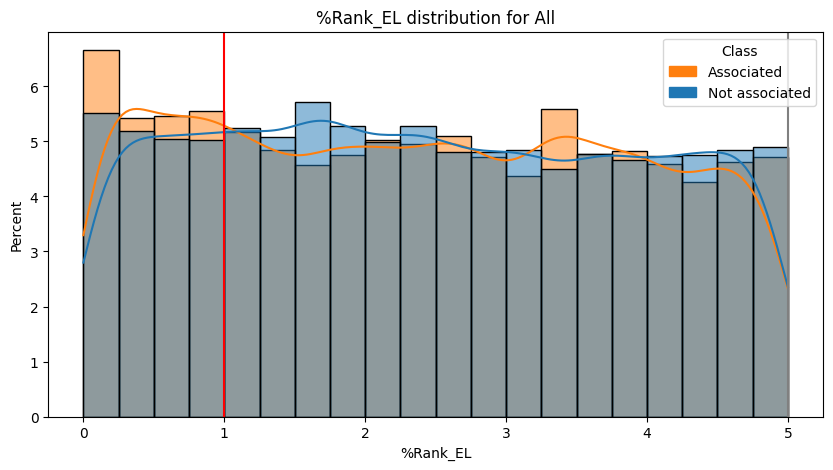

In [494]:
summary_associated['Class'] = 'Associated'
summary_not_associated['Class'] = 'Not associated'
summary_associated_bind = summary_associated[summary_associated['%Rank_EL'] <=5]
summary_not_associated_bind = summary_not_associated[summary_not_associated['%Rank_EL'] <=5]
plot_rank_distribution_in_percentage(summary_associated_bind, summary_not_associated_bind, bins=20, loc='upper right')
plt.axvline(x=5.,color='grey')
plt.axvline(x=1.,color='red')

(<Axes: xlabel='Class', ylabel='%Rank_EL'>,
 [<statannotations.Annotation.Annotation at 0x2c4dbbb50>])

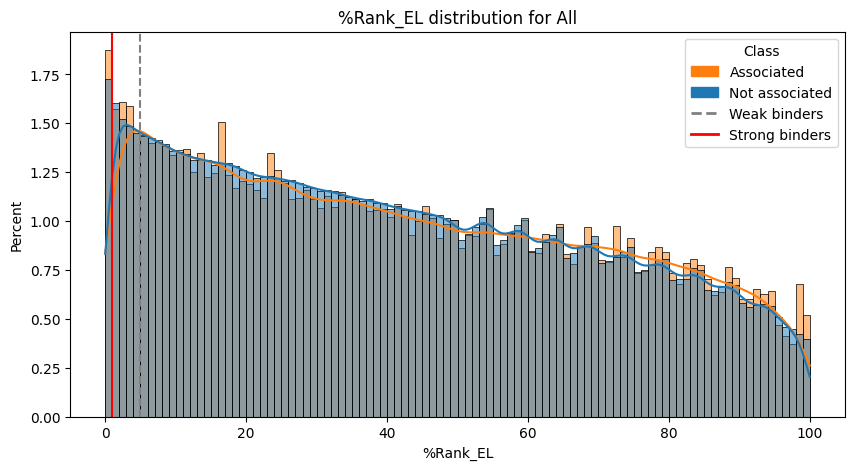

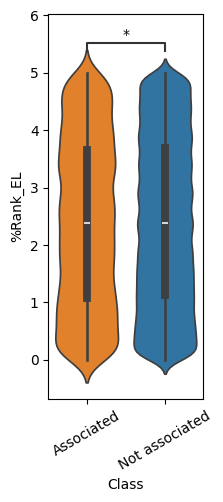

In [556]:

summary_associated['Class'] = 'Associated'
summary_non_associated_binders_all_combinations['Class'] = 'Not associated'
plot_rank_distribution_in_percentage(summary_associated, summary_non_associated_binders_all_combinations, bins = 100, loc='upper right')


df_test = pd.concat([summary_associated, summary_non_associated_binders_all_combinations])
df_test = df_test[df_test['%Rank_EL'] <= 5]
plt.figure(figsize=(2,5))
# ax =sns.boxplot(data=df_test, x='Class', y='%Rank_EL', hue='Class')
ax = sns.violinplot(data=df_test, x='Class', y='%Rank_EL', hue='Class', hue_order=['Not associated', 'Associated'])
plt.xticks(rotation=30)
# sns.swarmplot(data=df_test, x='Class', y='%Rank_EL')
# Get unique class names
classes = df_test['Class'].unique()
pair = [(classes[0], classes[1])]

# Run the t-test
data1 = df_test[df_test['Class'] == classes[0]]['%Rank_EL']
data2 = df_test[df_test['Class'] == classes[1]]['%Rank_EL']
# stat, pval = ttest_ind(data1, data2, equal_var=False)

# Add significance annotation
annotator = Annotator(ax, pair, data=df_test, x='Class', y='%Rank_EL')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annotator.apply_and_annotate()

In [ ]:
# Peptides from associations
# Load SupTable2.3 table and extract relevant columns: for each duplicate take minimum value of bonferroni and concatenate type
# of mutations.
# HLA only associated
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import openpyxl
import seaborn
from venn import venn

In [ ]:
# df = pd.read_excel('data/1-s2.0-S1074761323001711-mmc3.xlsx', sheet_name='SupTable2.3')
# It was renamed in just mmc3
df = pd.read_excel('data/mmc3.xlsx', sheet_name='SupTable2.3')

# General associated
# df2 = pd.read_excel('data/1-s2.0-S1074761323001711-mmc3.xlsx', sheet_name='SupTable2.2')
# It was renamed in just mmc3
df2 = pd.read_excel('data/mmc3.xlsx', sheet_name='SupTable2.2')


In [ ]:
# df3 = pd.read_excel('data/1-s2.0-S1074761323001711-mmc3.xlsx', sheet_name='SupTable2.1')
df3 = pd.read_excel('data/mmc3.xlsx', sheet_name='SupTable2.1')

In [ ]:
peptides_HLA = df.sort_values(by='peptide')
grouped_peptide_variant = peptides_HLA.groupby(['Type', 'peptide']).count()[['Variant']].reset_index()
grouped_peptide_variant.columns = ['Type', 'peptide', 'count']

In [ ]:
len(set(df2['peptide']))

511

In [ ]:
summary_associated['Class'] = 'Associated'
summary_not_associated['Class'] = 'Not associated'
summary_associated_bind = summary_associated[summary_associated['%Rank_EL'] <=5]
summary_not_associated_bind = summary_not_associated[summary_not_associated['%Rank_EL'] <=5]
plot_rank_distribution_in_percentage(summary_associated_bind, summary_not_associated_bind, bins=20, loc='upper right')
plt.axvline(x=5.,color='grey')
plt.axvline(x=1.,color='red')

(0.0, 100.0)
[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]


(0.0, 100.0)

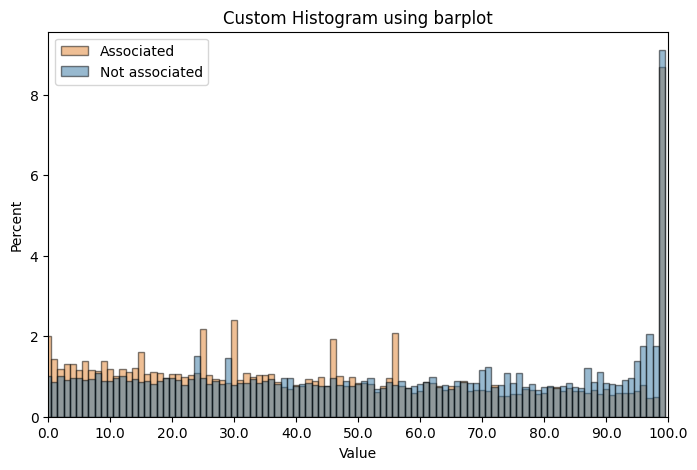

In [440]:
## Custom histogram
value = 100
bins=100
bin_counts, bin_edges = np.histogram(out_only_elisa[(out_only_elisa['%Rank_EL'] <=value) & (out_only_elisa['Class'] == 'Associated')]['%Rank_EL'], bins=bins)

# Create a DataFrame for plotting
df_histo = pd.DataFrame({
    "bin_center": (bin_edges[:-1] + bin_edges[1:]) / 2,  # Midpoints of bins
    "count": bin_counts,
    "percent": (bin_counts/len(out_only_elisa[(out_only_elisa['Class'] == 'Associated')]))*100
})


# # Plot using barplot
plt.figure(figsize=(8, 5))
sns.barplot(x="bin_center", y="percent", data=df_histo, color="tab:orange", width=1.0, edgecolor='black', alpha=0.5, label='Associated')
plt.xlabel("Value")
plt.ylabel("Percent")
plt.xlim((0,100))
plt.title("Custom Histogram using barplot")
# Define x-ticks dynamically based on max bin_center
print(plt.xlim())

tick_positions = np.linspace(0, plt.xlim()[1], 10 + 1)  # +1 to include last point
print(tick_positions)
plt.xticks(ticks=tick_positions, labels=tick_positions)
# df_histo
# Not associated
bin_counts, bin_edges = np.histogram(out_only_elisa[(out_only_elisa['%Rank_EL'] <=value) & (out_only_elisa['Class'] == 'Not associated')]['%Rank_EL'], bins=bins)
# Create a DataFrame for plotting
df_histo_2 = pd.DataFrame({
    "bin_center": (bin_edges[:-1] + bin_edges[1:]) / 2,  # Midpoints of bins
    "count": bin_counts,
    "percent": (bin_counts/len(out_only_elisa[(out_only_elisa['Class'] == 'Not associated')]))*100
})

# # # # Plot using barplot
sns.barplot(x="bin_center", y="percent", data=df_histo_2, color="tab:blue", width=1.0, edgecolor='black',alpha=0.5, label='Not associated')
plt.legend()
plt.xlim((0,100))


In [275]:
out_only_elisa

,Pos,MHC,Peptide,Of,Core,Core_Rel,peptide_name,Score_EL,%Rank_EL,Exp_Bind,BindLevel,Class
0,449,DRB1_0701,RTEYVETTSTEYTSG,3,YVETTSTEY,1.000,prot_16932,0.937196,0.09,NA,<=SB,Associated
1,297,DRB1_0701,YKQIFYTVSANLPNN,3,IFYTVSANL,0.940,prot_16932,0.915952,0.14,NA,<=SB,Associated
2,448,DRB1_0701,NRTEYVETTSTEYTS,4,YVETTSTEY,1.000,prot_16932,0.911768,0.16,NA,<=SB,Associated
3,298,DRB1_0701,KQIFYTVSANLPNNP,2,IFYTVSANL,0.793,prot_16932,0.884898,0.23,NA,<=SB,Associated
4,296,DRB1_0701,AYKQIFYTVSANLPN,4,IFYTVSANL,0.973,prot_16932,0.873117,0.26,NA,<=SB,Associated
...,...,...,...,...,...,...,...,...,...,...,...,...
50755,351,HLA-DQA10103-DQB10501,GKEDNKKPGKEDGNK,5,KKPGKEDGN,0.367,prot_19456,0.000911,95.00,NA,None,Associated
50756,366,HLA-DQA10103-DQB10501,PGKEDNKKPGKEDGN,6,KKPGKEDGN,0.167,prot_19456,0.000871,95.00,NA,None,Associated
50757,350,HLA-DQA10103-DQB10501,PGKEDNKKPGKEDGN,6,KKPGKEDGN,0.167,prot_19456,0.000871,95.00,NA,None,Associated
50758,365,HLA-DQA10103-DQB10501,KPGKEDNKKPGKEDG,2,GKEDNKKPG,0.313,prot_19456,0.000749,95.00,NA,None,Associated


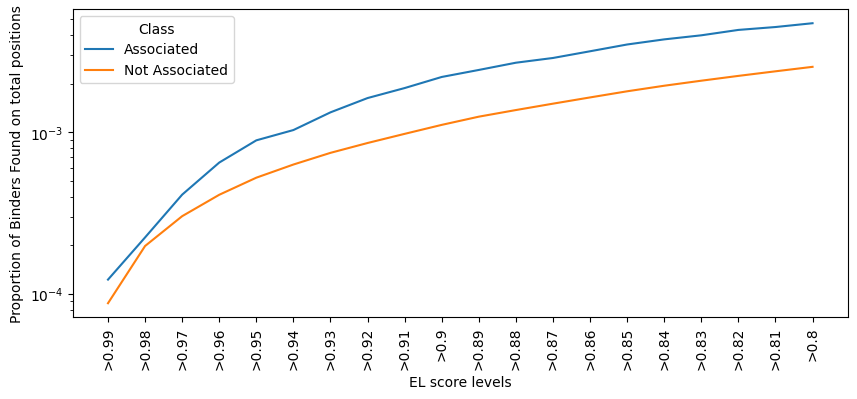

In [ ]:
EL_levels = np.arange(0.99, 0.79, -0.01)

list_EL_associated = []
list_EL_not_associated = []
for level in EL_levels:
    summary_associated['Score_EL'] = summary_associated['Score_EL'].astype(float)
    list_EL_associated.append(len(summary_associated[summary_associated['Score_EL'] > level]) / len(summary_associated))
    summary_non_associated_binders_all_combinations['Score_EL'] = summary_non_associated_binders_all_combinations['Score_EL'].astype(float)
    list_EL_not_associated.append(len(summary_non_associated_binders_all_combinations[summary_non_associated_binders_all_combinations['Score_EL'] > level]) / len(summary_non_associated_binders_all_combinations))

EL_levels_factorized = [f'>{str(round(x,2))}' for x in EL_levels]
comparison_EL_scores_associated = pd.DataFrame({'Proportion of Binders Found on total positions' : list_EL_associated, 'EL score levels' : EL_levels_factorized, 'Class' : 'Associated'})
comparison_EL_scores_not_associated = pd.DataFrame({'Proportion of Binders Found on total positions' : list_EL_not_associated, 'EL score levels' : EL_levels_factorized, 'Class' : 'Not Associated'})
comparison_EL_scores = pd.concat([comparison_EL_scores_associated, comparison_EL_scores_not_associated])
comparison_EL_scores.sort_values(by='EL score levels', ascending=False, inplace=True)
comparison_EL_scores['EL score levels'] = comparison_EL_scores['EL score levels'].astype('category')
# Reverse the order of categories
comparison_EL_scores['EL score levels'] = comparison_EL_scores['EL score levels'].cat.reorder_categories(
    comparison_EL_scores['EL score levels'].cat.categories[::-1], ordered=True
)

plt.figure(figsize=(10,4))
sns.lineplot(data=comparison_EL_scores, x='EL score levels', y='Proportion of Binders Found on total positions', hue='Class');
plt.yscale('log')
plt.xticks(rotation=90);
